In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/inference/To_cho_ti_202511142108_ccy1m.mp4
/kaggle/input/inference/z7224305271068_c6e389020882b5dbe2ec816b3e17cdee.jpg
/kaggle/input/inference/WIN_20251114_18_57_02_Pro.mp4
/kaggle/input/inference/WIN_20251114_18_56_01_Pro.jpg
/kaggle/input/inference/7224333875093.mp4
/kaggle/input/inference/z7224345755978_8eea11e76384001f7c58383d190b55b5.jpg
/kaggle/input/inference/To_video_di_202511142045_gf4lz.mp4
/kaggle/input/inference/7224345953736.mp4
/kaggle/input/stdl-facepad/pytorch/default/1/checkpoint_epoch_11.pth
/kaggle/input/dfas-dataset/DFAS/metadata/train_metadata.csv
/kaggle/input/dfas-dataset/DFAS/metadata/test_metadata.csv
/kaggle/input/dfas-dataset/DFAS/data_train/eivxffliio.mp4
/kaggle/input/dfas-dataset/DFAS/data_train/dwediigjit.mp4
/kaggle/input/dfas-dataset/DFAS/data_train/asvcrfdpnq.mp4
/kaggle/input/dfas-dataset/DFAS/data_train/dntkzzzcdh.mp4
/kaggle/input/dfas-dataset/DFAS/data_train/aczrgyricp.mp4
/kaggle/input/dfas-dataset/DFAS/data_train/dsgpbgsrdm.mp4
/kag

In [2]:
!pip install uv
!uv pip install decord

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 69.0 MB/s eta 0:00:00:00:0100:01
Using Python 3.11.13 environment at: /usr
Resolved 14 packages in 228ms                                        
Prepared 1 package in 220ms                                              
Installed 1 package in 4ms                                  
 + decord==0.6.0


In [3]:
import cv2
import torch
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import albumentations as A
from albumentations.pytorch import ToTensorV2
import pickle
import os
from decord import VideoReader, cpu, gpu
import decord
from PIL import Image
import gc

# Set decord to use numpy output
decord.bridge.set_bridge('native')

class FASDataset(Dataset):
    def __init__(self, csv_path, frame_size=224, num_frames=16, cache_dir="./cache", 
                 is_training=True, base_dir=None, use_cache=True, device=cpu(0)):
        self.df = pd.read_csv(csv_path)
        self.frame_size = frame_size
        self.num_frames = num_frames
        self.cache_dir = Path(cache_dir)
        self.cache_dir.mkdir(exist_ok=True)
        self.is_training = is_training
        self.base_dir = base_dir
        self.use_cache = use_cache
        self.device = device
        
        # Augmentation cho training
        if is_training:
            self.transform = A.Compose([
                A.Resize(frame_size, frame_size),
                A.HorizontalFlip(p=0.5),
                A.RandomBrightnessContrast(p=0.2),
                A.GaussNoise(p=0.3),
                A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ToTensorV2(),
            ])
        else:
            self.transform = A.Compose([
                A.Resize(frame_size, frame_size),
                A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ToTensorV2(),
            ])
    
    def __len__(self):
        return len(self.df)
    
    def _load_frames_from_video(self, video_path):
        """Đọc frames từ video sử dụng decord"""
        try:
            vr = VideoReader(video_path, ctx=self.device)
            total_frames = len(vr)
            
            # Uniform sampling frames
            if total_frames > self.num_frames:
                indices = np.linspace(0, total_frames - 1, self.num_frames, dtype=int)
            else:
                indices = np.arange(total_frames)
            
            # Get batch of frames
            frames = vr.get_batch(indices).asnumpy()  # (T, H, W, C)
            frames = np.array(frames)  # Ensure it's numpy array
            
            # Convert BGR to RGB if needed
            if frames.shape[-1] == 3:
                frames = frames[..., ::-1]  # BGR to RGB
            
            return frames
            
        except Exception as e:
            print(f"Error loading video {video_path}: {e}")
            # Return black frames as fallback
            return np.zeros((self.num_frames, self.frame_size, self.frame_size, 3), dtype=np.uint8)
    
    def _load_frames_from_image(self, image_path):
        """Đọc single frame từ ảnh sử dụng decord/PIL"""
        try:
            # Sử dụng PIL để đọc ảnh
            image = Image.open(image_path)
            image = image.convert('RGB')
            
            # Convert to numpy array
            frame = np.array(image)
            
            # Tạo multiple frames từ cùng một ảnh (lặp lại)
            frames = np.stack([frame] * self.num_frames, axis=0)  # (T, H, W, C)
            
            return frames
            
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            # Return black frames as fallback
            return np.zeros((self.num_frames, self.frame_size, self.frame_size, 3), dtype=np.uint8)
    
    def _process_frames(self, frames):
        """Xử lý frames: sampling, padding, tạo mask"""
        # frames shape: (T, H, W, C) hoặc (H, W, C) cho ảnh single
        
        # Nếu là ảnh single đã được stack thành (T, H, W, C)
        if len(frames.shape) == 4 and frames.shape[0] == self.num_frames:
            sampled_frames = frames
            original_length = self.num_frames  # Toàn bộ frames là thật
        else:
            # Đảm bảo frames có shape (T, H, W, C)
            if len(frames.shape) == 3:
                frames = np.expand_dims(frames, axis=0)
            
            # Sampling frames nếu cần
            total_frames = frames.shape[0]
            if total_frames > self.num_frames:
                indices = np.linspace(0, total_frames - 1, self.num_frames, dtype=int)
                sampled_frames = frames[indices]
                original_length = self.num_frames
            else:
                sampled_frames = frames
                original_length = total_frames
        
        # Padding nếu thiếu frames
        if sampled_frames.shape[0] < self.num_frames:
            padding_count = self.num_frames - sampled_frames.shape[0]
            padding_frames = np.zeros((padding_count, *sampled_frames.shape[1:]), dtype=sampled_frames.dtype)
            sampled_frames = np.concatenate([sampled_frames, padding_frames], axis=0)
            original_length = sampled_frames.shape[0] - padding_count
        
        # Tạo mask: 1 cho frame thật, 0 cho frame padding
        mask = torch.ones(self.num_frames)
        if sampled_frames.shape[0] > original_length:
            mask[original_length:] = 0
        
        # Transform frames
        transformed_frames = []
        for i in range(self.num_frames):
            frame = sampled_frames[i]
            # Đảm bảo frame có dtype uint8
            if frame.dtype != np.uint8:
                frame = frame.astype(np.uint8)
            
            transformed = self.transform(image=frame)['image']  # (C, H, W)
            transformed_frames.append(transformed)
        
        # Stack thành tensor: T x C x H x W
        frames_tensor = torch.stack(transformed_frames)
        
        return frames_tensor, mask
    
    def preload_cache(self):
        """Preload toàn bộ dataset vào cache"""
        if not self.use_cache:
            return
            
        print("Preloading dataset to cache...")
        for idx in range(len(self.df)):
            row = self.df.iloc[idx]
            file_path = row['path']
            uuid = row['uuid']
            cache_path = self.cache_dir / f"{uuid}.pkl"
            
            # Nếu chưa có cache, tạo mới
            if not cache_path.exists():
                if self.base_dir:
                    full_path = os.path.join(self.base_dir, file_path)
                else:
                    full_path = file_path
                
                try:
                    # Đọc và xử lý frames
                    if file_path.lower().endswith(('.mp4', '.avi', '.mov', '.mkv')):
                        frames = self._load_frames_from_video(full_path)
                    else:
                        frames = self._load_frames_from_image(full_path)
                    
                    frames_tensor, mask = self._process_frames(frames)
                    
                    # Lưu vào cache
                    with open(cache_path, 'wb') as f:
                        pickle.dump({'frames': frames_tensor, 'mask': mask}, f)
                    
                    # Giải phóng memory
                    del frames, frames_tensor, mask
                    gc.collect()
                    
                except Exception as e:
                    print(f"Error processing {full_path}: {e}")
                    continue
            
            if (idx + 1) % 100 == 0:
                print(f"Processed {idx + 1}/{len(self.df)} samples")
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        file_path = row['path']
        label = row['label']
        uuid = row['uuid']
        
        # Kiểm tra cache
        cache_path = self.cache_dir / f"{uuid}.pkl"
        
        if self.use_cache and cache_path.exists():
            # Load từ cache
            try:
                with open(cache_path, 'rb') as f:
                    cached_data = pickle.load(f)
                frames_tensor = cached_data['frames']
                mask = cached_data['mask']
            except Exception as e:
                print(f"Error loading cache for {uuid}: {e}")
                # Fallback: load trực tiếp
                frames_tensor, mask = self._load_and_process_file(file_path)
        else:
            # Load và xử lý trực tiếp
            frames_tensor, mask = self._load_and_process_file(file_path)
            
            # Lưu vào cache nếu enabled
            if self.use_cache:
                try:
                    with open(cache_path, 'wb') as f:
                        pickle.dump({'frames': frames_tensor, 'mask': mask}, f)
                except Exception as e:
                    print(f"Error saving cache for {uuid}: {e}")
        
        return {
            'frames': frames_tensor,  # T x C x H x W
            'mask': mask,            # T
            'label': torch.tensor(label, dtype=torch.long),
            'uuid': uuid
        }
    
    def _load_and_process_file(self, file_path):
        """Helper function để load và process file"""
        if self.base_dir:
            full_path = os.path.join(self.base_dir, file_path)
        else:
            full_path = file_path
        
        # Đọc frames
        if file_path.lower().endswith(('.mp4', '.avi', '.mov', '.mkv')):
            frames = self._load_frames_from_video(full_path)
        else:
            frames = self._load_frames_from_image(full_path)
        
        # Process frames
        frames_tensor, mask = self._process_frames(frames)
        
        # Giải phóng memory
        del frames
        gc.collect()
        
        return frames_tensor, mask

def collate_fn(batch):
    """Collate function để tạo batch - optimized for memory"""
    frames = torch.stack([item['frames'] for item in batch])  # B x T x C x H x W
    masks = torch.stack([item['mask'] for item in batch])     # B x T
    labels = torch.stack([item['label'] for item in batch])   # B
    uuids = [item['uuid'] for item in batch]                  # B
    
    return {
        'frames': frames,
        'mask': masks,
        'label': labels,
        'uuid': uuids
    }

In [4]:
#CDCN
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class CDCN(nn.Module):
    """CDCN feature extractor với residual connections"""
    def __init__(self, in_channels=3, feature_dim=512):
        super(CDCN, self).__init__()
        
        self.initial = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        self.layer1 = self._make_layer(64, 64, 2, stride=1)
        self.layer2 = self._make_layer(64, 128, 2, stride=2)
        self.layer3 = self._make_layer(128, 256, 2, stride=2)
        self.layer4 = self._make_layer(256, 512, 2, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, feature_dim)
        
    def _make_layer(self, in_channels, out_channels, blocks, stride):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride))
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        # x: B x T x C x H x W
        batch_size, num_frames = x.shape[0], x.shape[1]
        
        # Reshape để xử lý tất cả frames cùng lúc
        x = x.view(batch_size * num_frames, *x.shape[2:])
        
        x = self.initial(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        
        # Reshape lại về dạng B x T x feature_dim
        x = x.view(batch_size, num_frames, -1)
        
        return x

In [5]:
#Res ViT
import timm
import torchvision.models as models

class ResNetBranch(nn.Module):
    def __init__(self, input_dim=512, output_dim=256, pretrained=True):
        super(ResNetBranch, self).__init__()
        # Sử dụng ResNet18 pretrained nhẹ
        self.resnet = timm.create_model('resnet18', pretrained=pretrained, num_classes=0)
        feature_dim = self.resnet.num_features
        
        self.projector = nn.Sequential(
            nn.Linear(feature_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, output_dim)
        )
    
    def forward(self, x):
        # x: B x T x C x H x W
        batch_size, num_frames = x.shape[0], x.shape[1]
        
        # Process each frame
        x = x.view(batch_size * num_frames, *x.shape[2:])
        features = self.resnet(x)
        features = self.projector(features)
        
        # Reshape back và average pooling theo thời gian
        features = features.view(batch_size, num_frames, -1)
        temporal_features = torch.mean(features, dim=1)  # B x output_dim
        
        return temporal_features

class ViTBranch(nn.Module):
    def __init__(self, input_dim=512, output_dim=256, num_frames=16, pretrained=True):
        super(ViTBranch, self).__init__()
        
        # Sử dụng ViT tiny pretrained
        self.vit = timm.create_model('vit_tiny_patch16_224', pretrained=pretrained, num_classes=0)
        vit_dim = self.vit.num_features
        
        # Projector để ánh xạ từ CDCN features sang ViT input
        self.input_projection = nn.Linear(input_dim, vit_dim)
        
        # Transformer encoder cho temporal modeling
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=vit_dim,
            nhead=8,
            dim_feedforward=1024,
            dropout=0.1,
            batch_first=True
        )
        self.temporal_encoder = nn.TransformerEncoder(encoder_layer, num_layers=3)
        
        # CLS token
        self.cls_token = nn.Parameter(torch.randn(1, 1, vit_dim))
        
        self.output_projection = nn.Linear(vit_dim, output_dim)
        
    def forward(self, x, mask=None):
        # x: B x T x input_dim (features từ CDCN)
        batch_size = x.shape[0]
        
        # Project features
        x = self.input_projection(x)  # B x T x vit_dim
        
        # Thêm CLS token
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)  # B x (T+1) x vit_dim
        
        # Extended mask cho CLS token
        if mask is not None:
            cls_mask = torch.ones(batch_size, 1, device=mask.device)
            extended_mask = torch.cat((cls_mask, mask), dim=1)
            # Transformer cần mask với shape: T x T hoặc B x T
            # Ở đây ta sử dụng padding mask
            padding_mask = ~extended_mask.bool()
        else:
            padding_mask = None
        
        # Temporal encoding
        x = self.temporal_encoder(x, src_key_padding_mask=padding_mask)
        
        # Lấy CLS token output
        cls_output = x[:, 0]  # B x vit_dim
        
        # Project to output dimension
        output = self.output_projection(cls_output)  # B x output_dim
        
        return output

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [6]:
#HeadModel
class CDRes_ViT(nn.Module):
    def __init__(self, num_classes=2, feature_dim=512, branch_dim=256, num_frames=16, alpha=0.5):
        super(CDRes_ViT, self).__init__()
        self.alpha = nn.Parameter(torch.tensor(alpha))  # Learnable alpha
        
        self.cdcn = CDCN(feature_dim=feature_dim)
        self.resnet_branch = ResNetBranch(input_dim=feature_dim, output_dim=branch_dim)
        self.vit_branch = ViTBranch(input_dim=feature_dim, output_dim=branch_dim, num_frames=num_frames)
        
        self.classifier = nn.Sequential(
            nn.Linear(branch_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x, mask=None):
        # x: B x T x C x H x W
        # mask: B x T
        
        # Feature extraction với CDCN
        cdcn_features = self.cdcn(x)  # B x T x feature_dim
        
        # Nhánh ResNet
        resnet_features = self.resnet_branch(x)  # B x branch_dim
        
        # Nhánh ViT
        vit_features = self.vit_branch(cdcn_features, mask)  # B x branch_dim
        
        # Kết hợp features
        combined_features = self.alpha * resnet_features + (1 - self.alpha) * vit_features
        
        # Classification
        logits = self.classifier(combined_features)
        
        return logits

In [7]:
#Focal Loss
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean', label_smoothing=0.0):
        """
        Focal Loss for imbalanced classification
        
        Args:
            alpha (Tensor, optional): Weighting factor for each class. 
                                     If None, no class weighting is applied.
            gamma (float): Focusing parameter. Higher gamma down-weights easy examples.
            reduction (str): 'mean', 'sum', or 'none'
            label_smoothing (float): Label smoothing factor
        """
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.label_smoothing = label_smoothing
        
    def forward(self, inputs, targets):
        """
        Args:
            inputs: (B, C) logits
            targets: (B,) class indices
        """
        num_classes = inputs.size(1)
        
        # Apply label smoothing if specified
        if self.label_smoothing > 0:
            confidence = 1.0 - self.label_smoothing
            low_confidence = self.label_smoothing / (num_classes - 1)
            
            one_hot = torch.zeros_like(inputs)
            one_hot.scatter_(1, targets.unsqueeze(1), 1)
            targets = one_hot * confidence + low_confidence
        
        # Compute cross entropy
        if self.label_smoothing > 0:
            log_probs = F.log_softmax(inputs, dim=1)
            ce_loss = - (targets * log_probs).sum(dim=1)
        else:
            ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        
        # Compute focal loss
        probs = torch.softmax(inputs, dim=1)
        
        if self.label_smoothing > 0:
            # For label smoothing, we need to compute the probability of true class
            true_class_probs = torch.sum(probs * targets, dim=1)
        else:
            # Get probability of true class
            true_class_probs = probs.gather(1, targets.unsqueeze(1)).squeeze()
        
        # Focal term
        focal_term = (1 - true_class_probs) ** self.gamma
        
        # Apply class weights if provided
        if self.alpha is not None:
            if self.alpha.device != inputs.device:
                self.alpha = self.alpha.to(inputs.device)
            
            if self.label_smoothing > 0:
                # For label smoothing, compute weighted average
                alpha_weights = torch.sum(self.alpha.unsqueeze(0) * targets, dim=1)
            else:
                alpha_weights = self.alpha[targets]
            
            focal_loss = alpha_weights * focal_term * ce_loss
        else:
            focal_loss = focal_term * ce_loss
        
        # Apply reduction
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

class BalancedFocalLoss(nn.Module):
    def __init__(self, class_counts=None, beta=0.999, gamma=2.0, label_smoothing=0.1):
        """
        Balanced Focal Loss with automatic class weighting
        
        Args:
            class_counts: List or tensor of class counts
            beta: Parameter for effective number of samples
            gamma: Focusing parameter
            label_smoothing: Label smoothing factor
        """
        super(BalancedFocalLoss, self).__init__()
        
        if class_counts is not None:
            self.alpha = self.compute_class_weights(class_counts, beta)
        else:
            self.alpha = None
            
        self.gamma = gamma
        self.label_smoothing = label_smoothing
        
    def compute_class_weights(self, class_counts, beta):
        """
        Compute class weights based on effective number of samples
        """
        class_counts = torch.tensor(class_counts, dtype=torch.float32)
        effective_num = 1.0 - torch.pow(beta, class_counts)
        weights = (1.0 - beta) / effective_num
        weights = weights / torch.sum(weights) * len(weights)  # Normalize
        return weights
    
    def forward(self, inputs, targets):
        focal_loss_fn = FocalLoss(
            alpha=self.alpha,
            gamma=self.gamma,
            reduction='mean',
            label_smoothing=self.label_smoothing
        )
        return focal_loss_fn(inputs, targets)

In [8]:
#Config

config = {
        'batch_size': 8,
        'num_frames': 16,
        'frame_size': 224,
        'learning_rate': 1e-4,
        'min_lr': 1e-6,
        'num_epochs': 15,
        'weight_decay': 1e-4,
        'grad_clip': 1.0,
        'use_amp': True,
        'random_state':312,
        'test_size':0.2,
        'save_step':5,
    
    #For focal loss
        'use_focal_loss': True,
        'focal_loss_type': 'balanced',  # 'balanced' or 'standard'
        'gamma': 2.0,                   # Focusing parameter
        'beta': 0.999,                  # For balanced focal loss
        'label_smoothing': 0.1,         # Label smoothing
        'use_class_weights': True       # Whether to use class weights
    }
    
    # Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
#Preprocess
from sklearn.model_selection import train_test_split
df = pd.read_csv("/kaggle/input/dfas-dataset/DFAS/metadata/train_metadata.csv")
df_train, df_val = train_test_split(df, test_size = config['test_size'], 
                                    random_state=config['random_state'], stratify=df["label"])
df_train.to_csv("train_metadata.csv", index=False)
df_val.to_csv("val_metadata.csv", index=False)

In [10]:
#Make Dataloader

train_dataset = FASDataset(
        csv_path='train_metadata.csv',
        frame_size=config['frame_size'],
        num_frames=config['num_frames'],
        is_training=True,
        base_dir = "/kaggle/input/dfas-dataset/DFAS/data_train"
    )
    
val_dataset = FASDataset(
        csv_path='val_metadata.csv', 
        frame_size=config['frame_size'],
        num_frames=config['num_frames'],
        is_training=False,
        base_dir = "/kaggle/input/dfas-dataset/DFAS/data_train"
    )
    
train_loader = DataLoader(
        train_dataset,
        batch_size=config['batch_size'],
        shuffle=True,
        collate_fn=collate_fn,
        num_workers=4,
        persistent_workers=False,
    )
    
val_loader = DataLoader(
        val_dataset,
        batch_size=config['batch_size'],
        shuffle=False,
        collate_fn=collate_fn,
        num_workers=4,
        persistent_workers=False,
    )

In [11]:
#Train loop

import torch
import torch.nn as nn
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm import tqdm
import numpy as np
from sklearn.metrics import f1_score, accuracy_score
import warnings
warnings.filterwarnings('ignore')

class Trainer:
    def __init__(self, model, train_loader, val_loader, device, config):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.config = config
        
        # Optimizer và scheduler
        self.optimizer = torch.optim.AdamW(
            model.parameters(), 
            lr=config['learning_rate'],
            weight_decay=config.get('weight_decay', 1e-4)
        )
        
        self.scheduler = CosineAnnealingLR(
            self.optimizer, 
            T_max=config['num_epochs'],
            eta_min=config.get('min_lr', 1e-6)
        )
        
        # Loss function
        self.criterion = self.setup_criterion()
        
        # Grad scaler cho mixed precision
        self.scaler = torch.cuda.amp.GradScaler(enabled=config.get('use_amp', True))
        
        self.best_val_acer = float('inf')


    def setup_criterion(self):
        """Setup loss function với focal loss cho imbalanced data"""
        if self.config.get('use_focal_loss', False):
            # Tính class counts
            class_counts = self.calculate_class_counts(self.train_loader)
            print(f"Class distribution: {class_counts}")
            
            if self.config.get('focal_loss_type') == 'balanced':
                return BalancedFocalLoss(
                    class_counts=class_counts,
                    beta=self.config.get('beta', 0.999),
                    gamma=self.config.get('gamma', 2.0),
                    label_smoothing=self.config.get('label_smoothing', 0.1)
                )
            else:
                # Standard focal loss với class weights
                total_samples = class_counts.sum().item()
                class_weights = total_samples / (len(class_counts) * class_counts.float())
                class_weights = class_weights.to(self.device)
                
                return FocalLoss(
                    alpha=class_weights,
                    gamma=self.config.get('gamma', 2.0),
                    reduction='mean',
                    label_smoothing=self.config.get('label_smoothing', 0.0)
                )
        else:
            # Standard cross entropy với class weights
            class_counts = self.calculate_class_counts(self.train_loader)
            total_samples = class_counts.sum().item()
            class_weights = total_samples / (len(class_counts) * class_counts.float())
            class_weights = class_weights.to(self.device)
            
            return nn.CrossEntropyLoss(
                weight=class_weights,
                label_smoothing=self.config.get('label_smoothing', 0.0)
            )
            
    
    def calculate_class_counts(self, dataloader):
        """Tính số lượng samples mỗi class"""
        class_counts = torch.zeros(2, dtype=torch.long)  # Giả sử 2 classes
        
        for batch in dataloader:
            labels = batch['label']
            for class_idx in range(2):
                class_counts[class_idx] += (labels == class_idx).sum().item()
                
        return class_counts

    
    def calculate_acer(self, y_true, y_pred):
        """Tính ACER (Average Classification Error Rate)"""
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
        
        # Giả sử class 0 là real, class 1 là fake
        real_indices = (y_true == 0)
        fake_indices = (y_true == 1)
        
        if np.sum(real_indices) == 0:
            apcer = 0  # Không có sample real
        else:
            # APCER: Attack Presentation Classification Error Rate
            apcer = np.sum(y_pred[real_indices] == 1) / np.sum(real_indices)
        
        if np.sum(fake_indices) == 0:
            bpcer = 0  # Không có sample fake
        else:
            # BPCER: Bona Fide Presentation Classification Error Rate  
            bpcer = np.sum(y_pred[fake_indices] == 0) / np.sum(fake_indices)
        
        # ACER: Average of APCER and BPCER
        acer = (apcer + bpcer) / 2
        return acer, apcer, bpcer
    
    def evaluate(self, dataloader, desc="Evaluating"):
        """Evaluation function với metrics đầy đủ"""
        self.model.eval()
        
        all_preds = []
        all_labels = []
        total_loss = 0.0
        
        with torch.no_grad():
            for batch in tqdm(dataloader, desc=desc, leave=False):
                frames = batch['frames'].to(self.device)
                mask = batch['mask'].to(self.device)
                labels = batch['label'].to(self.device)
                
                # Forward pass
                with torch.cuda.amp.autocast(enabled=self.config.get('use_amp', True)):
                    outputs = self.model(frames, mask)
                    loss = self.criterion(outputs, labels)
                
                total_loss += loss.item()
                
                # Predictions
                _, preds = torch.max(outputs, 1)
                
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        # Calculate metrics
        accuracy = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds, average='macro')
        acer, apcer, bpcer = self.calculate_acer(all_labels, all_preds)
        avg_loss = total_loss / len(dataloader)
        
        metrics = {
            'loss': avg_loss,
            'accuracy': accuracy,
            'f1_score': f1,
            'acer': acer,
            'apcer': apcer,
            'bpcer': bpcer
        }
        
        return metrics, all_preds, all_labels
    
    def train_epoch(self, epoch):
        """Train một epoch"""
        self.model.train()
        epoch_loss = 0.0
        all_preds = []
        all_labels = []
        
        pbar = tqdm(self.train_loader, desc=f'Epoch {epoch+1}/{self.config["num_epochs"]} - Training')
        
        for batch_idx, batch in enumerate(pbar):
            frames = batch['frames'].to(self.device)
            mask = batch['mask'].to(self.device)
            labels = batch['label'].to(self.device)
            
            self.optimizer.zero_grad()
            
            # Mixed precision training
            with torch.cuda.amp.autocast(enabled=self.config.get('use_amp', True)):
                outputs = self.model(frames, mask)
                loss = self.criterion(outputs, labels)
            
            # Backward với grad scaler
            self.scaler.scale(loss).backward()
            
            # Gradient clipping
            if self.config.get('grad_clip', 0) > 0:
                self.scaler.unscale_(self.optimizer)
                torch.nn.utils.clip_grad_norm_(
                    self.model.parameters(), 
                    self.config['grad_clip']
                )
            
            self.scaler.step(self.optimizer)
            self.scaler.update()
            
            # Update tracking
            epoch_loss += loss.item()
            
            # Predictions for metrics
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.detach().cpu().numpy())
            all_labels.extend(labels.detach().cpu().numpy())
            
            # Update progress bar
            current_lr = self.optimizer.param_groups[0]['lr']
            pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'LR': f'{current_lr:.2e}'
            })
        
        # Calculate epoch metrics
        avg_loss = epoch_loss / len(self.train_loader)
        accuracy = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds, average='macro')
        
        return avg_loss, accuracy, f1
    
    def train(self):
        """Full training loop"""
        print(f"Starting training for {self.config['num_epochs']} epochs...")
        print(f"Using device: {self.device}")
        print(f"Training samples: {len(self.train_loader.dataset)}")
        print(f"Validation samples: {len(self.val_loader.dataset)}")
        print("-" * 80)
        atrain_acc = []
        atrain_loss = []
        aval_acc = []
        aval_loss = []
        for epoch in range(self.config['num_epochs']):
            # Train one epoch
            train_loss, train_acc, train_f1 = self.train_epoch(epoch)

            atrain_loss.append(train_loss)
            atrain_acc.append(train_acc)
            
            # Update scheduler
            self.scheduler.step()
            
            # Evaluate
            val_metrics, _, _ = self.evaluate(self.val_loader, desc=f'Epoch {epoch+1} - Validating')
            
            # Print epoch results
            current_lr = self.optimizer.param_groups[0]['lr']
            print(f"\nEpoch {epoch+1}/{self.config['num_epochs']} Results:")
            print(f"LR: {current_lr:.2e} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Train F1: {train_f1:.4f}")
            print(f"Val Loss: {val_metrics['loss']:.4f} | Val Acc: {val_metrics['accuracy']:.4f}")
            print(f"Val F1: {val_metrics['f1_score']:.4f} | Val ACER: {val_metrics['acer']:.4f}")
            print(f"APCER: {val_metrics['apcer']:.4f} | BPCER: {val_metrics['bpcer']:.4f}")

            aval_acc.append(val_metrics["accuracy"])
            aval_loss.append(val_metrics["loss"])
            
            # Save best model
            if val_metrics['acer'] < self.best_val_acer:
                self.best_val_acer = val_metrics['acer']
                self.save_checkpoint(epoch, is_best=True)
                print(f"🔥 New best model saved! ACER: {val_metrics['acer']:.4f}")
            
            print("-" * 80)
            if not epoch%self.config["save_step"]:
                self.save_checkpoint(epoch)
        # Final evaluation
        self.save_checkpoint(epoch)
        print("\nTraining completed!")
        print(f"Best validation ACER: {self.best_val_acer:.4f}")
        return {
            "train_loss":atrain_loss,
            "train_acc" :atrain_acc,
            "val_loss":aval_loss,
            "val_acc":aval_acc
        }
        
    
    def save_checkpoint(self, epoch, is_best=False):
        """Lưu checkpoint"""
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'scaler_state_dict': self.scaler.state_dict(),
            'best_val_acer': self.best_val_acer,
            'config': self.config
        }
        
        if is_best:
            torch.save(checkpoint, f"best_model.pth")
        torch.save(checkpoint, f"checkpoint_epoch_{epoch+1}.pth")
    
    def load_checkpoint(self, checkpoint_path):
        """Load checkpoint"""
        checkpoint = torch.load(checkpoint_path, map_location=self.device, weights_only=False)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        self.scaler.load_state_dict(checkpoint['scaler_state_dict'])
        self.best_val_acer = checkpoint['best_val_acer']
        
        print(f"Loaded checkpoint from epoch {checkpoint['epoch'] + 1}")
        print(f"Best ACER: {self.best_val_acer:.4f}")
    

In [12]:
model = CDRes_ViT(num_classes=2, feature_dim=900, 
                  branch_dim=256, num_frames=config["num_frames"], 
                  alpha=0.5).to(device)

# trainer = Trainer(model, train_loader, val_loader, device, config)
# history = trainer.train()

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

In [11]:
import gc
import psutil
import numpy as np
from tqdm import tqdm

def evaluate_model_cpu_optimized(model, test_loader, device, use_amp=True):
    """
    Evaluate model tiết kiệm RAM CPU
    """
    model.eval()
    
    # Sử dụng accumulation thay vì lưu toàn bộ arrays
    total_correct = 0
    total_samples = 0
    total_loss = 0.0
    confusion_counts = {'tp': 0, 'fp': 0, 'tn': 0, 'fn': 0}
    
    criterion = nn.CrossEntropyLoss()
    
    with torch.no_grad():
        for batch_idx, batch in enumerate(tqdm(test_loader, desc="Evaluating")):
            # QUAN TRỌNG: Xóa batch cũ khỏi RAM ngay lập tức
            # if batch_idx > 0:
            #     del batch
            #     gc.collect()
            
            # Load batch hiện tại
            frames = batch['frames'].to(device, non_blocking=True)
            mask = batch['mask'].to(device, non_blocking=True)
            labels = batch['label'].to(device, non_blocking=True)
            
            # Forward pass
            with torch.cuda.amp.autocast(enabled=use_amp):
                outputs = model(frames, mask)
                loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            
            # Tính predictions và metrics ngay
            _, preds = torch.max(outputs, 1)
            
            # Accuracy
            correct = (preds == labels).sum().item()
            total_correct += correct
            total_samples += labels.size(0)
            
            # Confusion matrix components - tính trên GPU rồi chuyển về CPU
            preds_cpu = preds.cpu()
            labels_cpu = labels.cpu()
            
            for i in range(len(preds_cpu)):
                true_label = labels_cpu[i].item()
                pred_label = preds_cpu[i].item()
                
                if true_label == 0:  # Real
                    if pred_label == 0:
                        confusion_counts['tn'] += 1
                    else:
                        confusion_counts['fp'] += 1
                else:  # Fake
                    if pred_label == 1:
                        confusion_counts['tp'] += 1
                    else:
                        confusion_counts['fn'] += 1
            
            # GIẢI PHÓNG MEMORY QUAN TRỌNG
            del frames, mask, labels, outputs, preds, preds_cpu, labels_cpu
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            gc.collect()
    
    # Tính metrics từ accumulated values
    accuracy = total_correct / total_samples if total_samples > 0 else 0
    avg_loss = total_loss / len(test_loader)
    
    # Tính các metrics khác
    tp, fp, tn, fn = confusion_counts['tp'], confusion_counts['fp'], confusion_counts['tn'], confusion_counts['fn']
    
    # F1 Score
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    # ACER
    apcer = fp / (tn + fp) if (tn + fp) > 0 else 0
    bpcer = fn / (tp + fn) if (tp + fn) > 0 else 0
    acer = (apcer + bpcer) / 2
    
    metrics = {
        'loss': avg_loss,
        'accuracy': accuracy,
        'f1_score': f1,
        'acer': acer,
        'apcer': apcer,
        'bpcer': bpcer,
        'confusion_matrix': confusion_counts
    }
    
    return metrics


def example_evaluation_cpu_optimized(model, checkpoint, test_loader, device):
    """
    Example evaluation tối ưu RAM CPU
    """
    print("Initial RAM:", end=" ")
    print_memory_info()
    
    # Load checkpoint
    print("Loading checkpoint...")
    checkpoint = torch.load(checkpoint, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    
    # Giải phóng checkpoint
    del checkpoint
    gc.collect()
    
    print("RAM after loading model:", end=" ")
    print_memory_info()
    
    # Evaluate với phương pháp tiết kiệm RAM
    print("Evaluating...")
    metrics = evaluate_model_cpu_optimized(model, test_loader, device)
    
    print("RAM after evaluation:", end=" ")
    print_memory_info()
    
    print("\n" + "="*50)
    print("Evaluation Results:")
    print("="*50)
    print(f"Accuracy:  {metrics['accuracy']:.4f}")
    print(f"F1 Score:  {metrics['f1_score']:.4f}")
    print(f"ACER:      {metrics['acer']:.4f}")
    print(f"APCER:     {metrics['apcer']:.4f}")
    print(f"BPCER:     {metrics['bpcer']:.4f}")
    print("="*50)
    
    return metrics


def print_memory_info():
    """In thông tin memory usage"""
    process = psutil.Process()
    memory_info = process.memory_info()
    print(f"RAM Usage: {memory_info.rss / 1024**3:.2f} GB")
    print(f"Virtual Memory: {memory_info.vms / 1024**3:.2f} GB")

In [60]:
#Test Dataloader
test_ds = FASDataset(
        csv_path='/kaggle/input/dfas-dataset/DFAS/metadata/test_metadata.csv', 
        frame_size=config['frame_size'],
        num_frames=config['num_frames'],
        is_training=False,
        base_dir = "/kaggle/input/dfas-dataset/DFAS/data_test"
    )

test_loader = DataLoader(
        test_ds,
        batch_size=1,
        shuffle=False,
        collate_fn=collate_fn,
        persistent_workers=False,
        num_workers=4
    )

In [ ]:
#Test
example_evaluation_cpu_optimized(model,
                   test_loader = test_loader,
                   device=device,
                   checkpoint = "/kaggle/input/final-model/pytorch/default/1/checkpoint_epoch_15.pth"
)


In [59]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """
    Vẽ biểu đồ training history
    
    Parameters:
    history: dict chứa các mảng giá trị
        - train_loss: mảng train loss qua các epoch
        - train_acc: mảng train accuracy qua các epoch  
        - val_loss: mảng validation loss qua các epoch
        - val_acc: mảng validation accuracy qua các epoch
    """
    
    # Lấy số epoch
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Tạo figure với 2 subplot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Vẽ biểu đồ Loss
    ax1.plot(epochs, history['train_loss'], 'b-', label='Training Loss', linewidth=2)
    ax1.plot(epochs, history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Vẽ biểu đồ Accuracy
    ax2.plot(epochs, history['train_acc'], 'b-', label='Training Accuracy', linewidth=2)
    ax2.plot(epochs, history['val_acc'], 'r-', label='Validation Accuracy', linewidth=2)
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [ ]:
plot_training_history(history)

Using device: cuda
Loading model from /kaggle/input/final-model/pytorch/default/1/checkpoint_epoch_15.pth...
✅ Model loaded successfully!

IMAGE INFERENCE
Processing image: z7224345755978_8eea11e76384001f7c58383d190b55b5.jpg


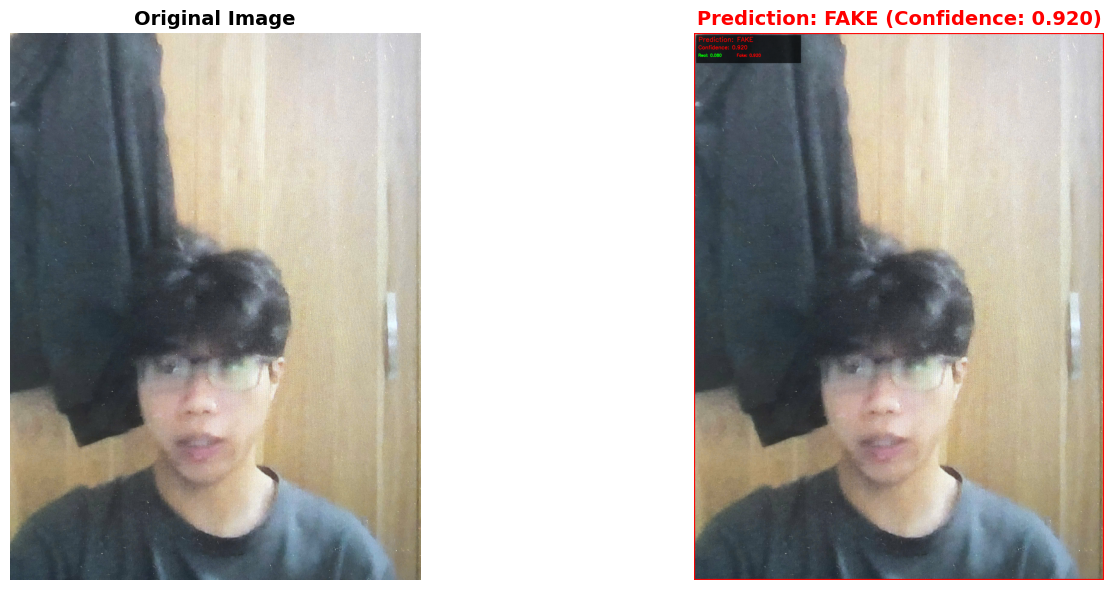

Result saved to: prediction_result.jpg

🎯 IMAGE PREDICTION RESULT:
   Class: FAKE
   Confidence: 0.9195
   Real probability: 0.0805
   Fake probability: 0.9195
Confidence level: VERY HIGH

VIDEO INFERENCE
🎥 Processing video: To_video_di_202511142045_gf4lz.mp4
Video info: 192 frames, sampled 16 frames


Creating result video: 100%|██████████| 192/192 [00:02<00:00, 95.36it/s] 


Result video saved to: result_video.mp4

VIDEO PREDICTION RESULT
Final Prediction: FAKE
Confidence: 0.9479
Real probability: 0.0521
Fake probability: 0.9479
Total frames: 192
Sampled frames: 16


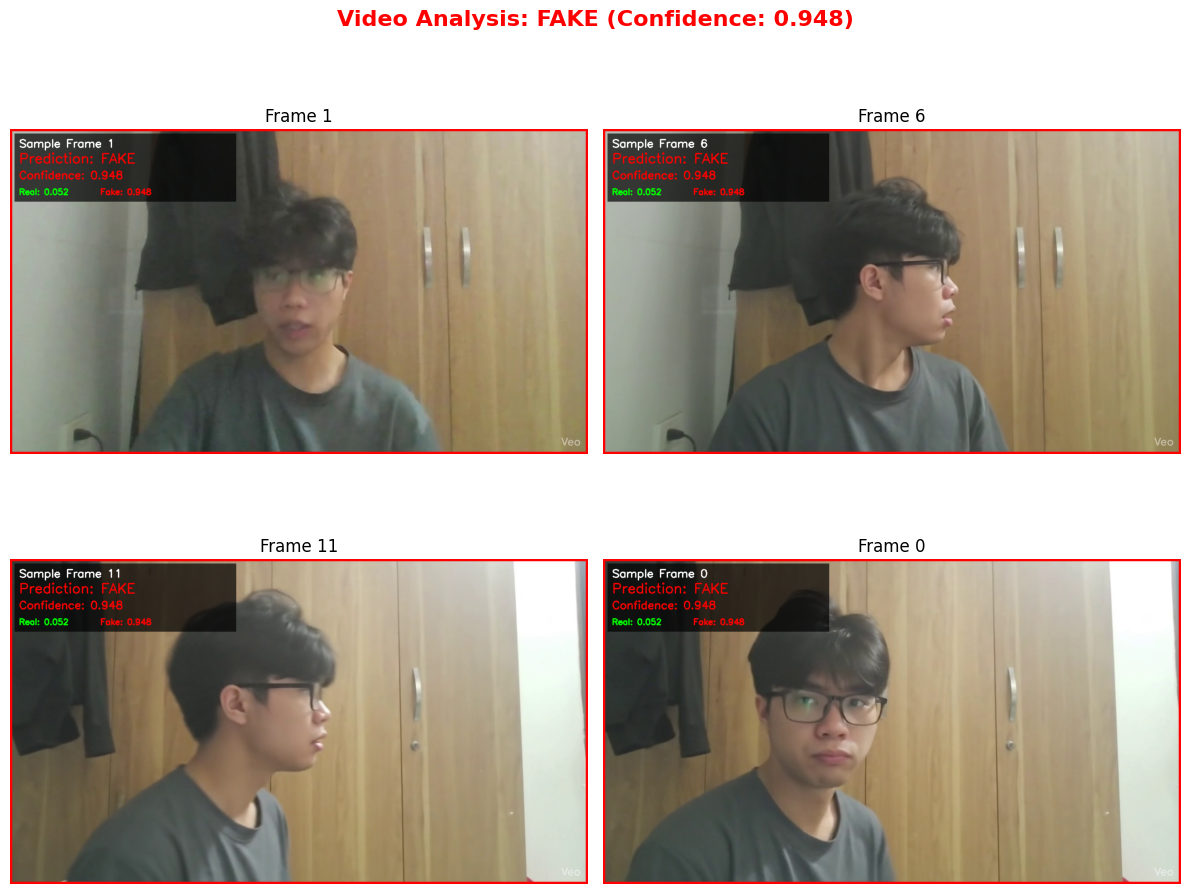


🎯 VIDEO PREDICTION RESULT:
   Class: FAKE
   Confidence: 0.9479
   Real probability: 0.0521
   Fake probability: 0.9479
Confidence level: VERY HIGH


In [16]:
#inference
import torch
import torch.nn as nn
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import glob
import os
from pathlib import Path
from decord import VideoReader, cpu
from tqdm import tqdm

class FASInference:
    def __init__(self, model, checkpoint_path, device, frame_size=224, num_frames=16):
        self.model = model
        self.checkpoint_path = checkpoint_path
        self.device = device
        self.frame_size = frame_size
        self.num_frames = num_frames
        
        # Load model weights
        self.load_model()
        
        # Transform cho inference
        self.transform = A.Compose([
            A.Resize(frame_size, frame_size),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2(),
        ])
        
        # Class names
        self.class_names = {0: 'REAL', 1: 'FAKE'}
        self.colors = {0: (0, 255, 0), 1: (255, 0, 0)}  # RGB: Xanh lá: REAL, Đỏ: FAKE
    
    def load_model(self):
        """Load model từ checkpoint"""
        print(f"Loading model from {self.checkpoint_path}...")
        checkpoint = torch.load(self.checkpoint_path, map_location=self.device, weights_only=False)
        
        if 'model_state_dict' in checkpoint:
            self.model.load_state_dict(checkpoint['model_state_dict'])
        else:
            self.model.load_state_dict(checkpoint)
            
        self.model.to(self.device)
        self.model.eval()
        print("✅ Model loaded successfully!")
    
    def preprocess_image(self, image_path):
        """Preprocess image cho inference - trả về RGB"""
        # Đọc ảnh
        image = cv2.imread(image_path)
        if image is None:
            raise ValueError(f"Could not load image from {image_path}")
        
        # Chuyển sang RGB
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        original_size = image_rgb.shape[:2]  # (height, width)
        
        # Tạo multiple frames từ cùng một ảnh
        frames = []
        for _ in range(self.num_frames):
            transformed = self.transform(image=image_rgb)['image']  # (C, H, W)
            frames.append(transformed)
        
        # Stack thành tensor: T x C x H x W
        frames_tensor = torch.stack(frames)
        
        # Tạo mask toàn 1 (tất cả frames đều là thật)
        mask = torch.ones(self.num_frames)
        
        # Thêm batch dimension: 1 x T x C x H x W
        frames_tensor = frames_tensor.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        return frames_tensor, mask, image_rgb, original_size
    
    def preprocess_video(self, video_path):
        """Preprocess video - trả về frames RGB"""
        vr = VideoReader(video_path, ctx=cpu(0))
        total_frames = len(vr)
        
        # Lấy frames đại diện từ toàn bộ video
        if total_frames > self.num_frames:
            # Uniform sampling: lấy đều các frames
            indices = np.linspace(0, total_frames-1, self.num_frames, dtype=int)
            frames = vr.get_batch(indices).asnumpy()  # (T, H, W, C) - RGB
        else:
            # Nếu video ngắn, lấy tất cả frames
            frames = vr.get_batch(list(range(total_frames))).asnumpy()
        
        # Lấy frame đầu tiên để visualization (đã là RGB)
        sample_frame = frames[0] if len(frames) > 0 else None
        
        # Transform frames cho model
        transformed_frames = []
        for frame in frames:
            transformed = self.transform(image=frame)['image']
            transformed_frames.append(transformed)
        
        # Stack thành tensor: T x C x H x W
        frames_tensor = torch.stack(transformed_frames)
        
        # Tạo mask
        mask = torch.ones(self.num_frames)
        if len(frames) < self.num_frames:
            mask[len(frames):] = 0
        
        # Thêm batch dimension
        frames_tensor = frames_tensor.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        return frames_tensor, mask, frames, sample_frame, total_frames
    
    def predict(self, frames_tensor, mask):
        """Dự đoán cho input tensor - trả về prediction cho toàn bộ sequence"""
        with torch.no_grad():
            frames_tensor = frames_tensor.to(self.device)
            mask = mask.to(self.device)
            
            outputs = self.model(frames_tensor, mask)
            probabilities = torch.softmax(outputs, dim=1)
            predicted_class = torch.argmax(outputs, dim=1).item()
            confidence = probabilities[0, predicted_class].item()
            
            return predicted_class, confidence, probabilities.cpu().numpy()[0]
    
    def draw_prediction_on_image(self, image_rgb, prediction, confidence, probabilities, title=None):
        """Vẽ prediction lên ảnh RGB"""
        # Tạo bản copy để vẽ
        result_image = image_rgb.copy()
        h, w = image_rgb.shape[:2]
        
        # Màu dựa trên prediction (RGB format)
        color = self.colors[prediction]
        class_name = self.class_names[prediction]
        
        # Vẽ background cho text (màu đen semi-transparent)
        overlay = result_image.copy()
        text_height = 160 if title else 140
        cv2.rectangle(overlay, (10, 10), (500, text_height), (0, 0, 0), -1)
        result_image = cv2.addWeighted(overlay, 0.7, result_image, 0.3, 0)
        
        # Vẽ text (sử dụng cv2 nhưng với màu RGB)
        font = cv2.FONT_HERSHEY_SIMPLEX
        
        # Thêm title nếu có
        y_offset = 40
        if title:
            cv2.putText(result_image, title, (20, y_offset), font, 0.8, (255, 255, 255), 2)
            y_offset += 35
        
        cv2.putText(result_image, f"Prediction: {class_name}", (20, y_offset), font, 1, color, 2)
        cv2.putText(result_image, f"Confidence: {confidence:.3f}", (20, y_offset + 35), font, 0.8, color, 2)
        cv2.putText(result_image, f"Real: {probabilities[0]:.3f}", (20, y_offset + 70), font, 0.6, (0, 255, 0), 2)
        cv2.putText(result_image, f"Fake: {probabilities[1]:.3f}", (200, y_offset + 70), font, 0.6, (255, 0, 0), 2)
        
        # Vẽ border với màu tương ứng
        cv2.rectangle(result_image, (0, 0), (w-1, h-1), color, 8)
        
        return result_image
    
    def inference_image(self, image_path, save_path=None, display=True):
        """
        Inference cho single image
        Returns: prediction, confidence, probabilities, result_image
        """
        print(f"Processing image: {os.path.basename(image_path)}")
        
        try:
            # Preprocess - trả về ảnh RGB
            frames_tensor, mask, original_image, original_size = self.preprocess_image(image_path)
            
            # Predict
            predicted_class, confidence, probabilities = self.predict(frames_tensor, mask)
            
            # Vẽ kết quả lên ảnh RGB
            result_image = self.draw_prediction_on_image(
                original_image, predicted_class, confidence, probabilities
            )
            
            # Resize về kích thước gốc nếu cần
            if result_image.shape[:2] != original_size:
                result_image = cv2.resize(result_image, (original_size[1], original_size[0]))
            
            # Hiển thị
            if display:
                self._display_image_result(original_image, result_image, predicted_class, confidence)
            
            # Lưu nếu có path
            if save_path:
                # Chuyển sang BGR để lưu với OpenCV
                save_image_bgr = cv2.cvtColor(result_image, cv2.COLOR_RGB2BGR)
                cv2.imwrite(save_path, save_image_bgr)
                print(f"Result saved to: {save_path}")
            
            # Print kết quả
            self._print_prediction_result(predicted_class, confidence, probabilities, "IMAGE")
            
            return predicted_class, confidence, probabilities, result_image
            
        except Exception as e:
            print(f"❌ Error processing image {image_path}: {e}")
            return None, None, None, None
    
    def inference_video(self, video_path, output_path=None, display_samples=True):
        """
        Inference cho toàn bộ video
        Returns: prediction, confidence, probabilities, sample_frames
        """
        print(f"🎥 Processing video: {os.path.basename(video_path)}")
        
        try:
            # Preprocess - trả về frames RGB
            frames_tensor, mask, all_frames, sample_frame, total_frames = self.preprocess_video(video_path)
            
            # Predict TOÀN BỘ VIDEO
            predicted_class, confidence, probabilities = self.predict(frames_tensor, mask)
            
            print(f"Video info: {total_frames} frames, sampled {len(all_frames)} frames")
            
            # Tạo output video với kết quả
            result_frames = []
            if output_path:
                result_frames = self._create_video_with_prediction(
                    video_path, predicted_class, confidence, probabilities, output_path
                )
            
            # Hiển thị kết quả và sample frames
            if display_samples:
                self._display_video_result(all_frames, predicted_class, confidence, probabilities, total_frames)
            
            # Print kết quả
            self._print_prediction_result(predicted_class, confidence, probabilities, "VIDEO")
            
            return predicted_class, confidence, probabilities, result_frames
            
        except Exception as e:
            print(f"❌ Error processing video {video_path}: {e}")
            return None, None, None, None
    
    def _create_video_with_prediction(self, video_path, prediction, confidence, probabilities, output_path):
        """Tạo video kết quả với prediction được vẽ lên mọi frame"""
        try:
            vr = VideoReader(video_path, ctx=cpu(0))
            total_frames = len(vr)
            fps = vr.get_avg_fps()
            
            frame_width = int(vr[0].shape[1])
            frame_height = int(vr[0].shape[0])
            
            fourcc = cv2.VideoWriter_fourcc(*'mp4v')
            out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))
            
            result_frames = []
            
            for i in tqdm(range(total_frames), desc="Creating result video"):
                frame = vr[i].asnumpy()  # RGB từ decord
                
                # Vẽ prediction lên frame
                result_frame = self.draw_prediction_on_image(
                    frame, prediction, confidence, probabilities, 
                    title=f"Frame: {i+1}/{total_frames}"
                )
                
                # Chuyển sang BGR để lưu
                result_frame_bgr = cv2.cvtColor(result_frame, cv2.COLOR_RGB2BGR)
                out.write(result_frame_bgr)
                result_frames.append(result_frame)
            
            out.release()
            print(f"Result video saved to: {output_path}")
            
            return result_frames
            
        except Exception as e:
            print(f"⚠️  Could not create result video: {e}")
            return []
    
    def _display_image_result(self, original_image, result_image, prediction, confidence):
        """Hiển thị kết quả cho ảnh"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
        # Ảnh gốc
        ax1.imshow(original_image)
        ax1.set_title("Original Image", fontsize=14, fontweight='bold')
        ax1.axis('off')
        
        # Ảnh kết quả
        ax2.imshow(result_image)
        ax2.set_title(f"Prediction: {self.class_names[prediction]} (Confidence: {confidence:.3f})", 
                     fontsize=14, fontweight='bold',
                     color='green' if prediction == 0 else 'red')
        ax2.axis('off')
        
        plt.tight_layout()
        plt.show()
    
    def _display_video_result(self, frames, prediction, confidence, probabilities, total_frames):
        """Hiển thị kết quả và sample frames từ video"""
        print(f"\n{'='*60}")
        print(f"VIDEO PREDICTION RESULT")
        print(f"{'='*60}")
        print(f"Final Prediction: {self.class_names[prediction]}")
        print(f"Confidence: {confidence:.4f}")
        print(f"Real probability: {probabilities[0]:.4f}")
        print(f"Fake probability: {probabilities[1]:.4f}")
        print(f"Total frames: {total_frames}")
        print(f"Sampled frames: {len(frames)}")
        print(f"{'='*60}")
        
        # Hiển thị sample frames
        if len(frames) >= 4:
            fig, axes = plt.subplots(2, 2, figsize=(12, 10))
            axes = axes.flatten()
            
            sample_indices = [0, len(frames)//3, 2*len(frames)//3, -1]
            
            for i, idx in enumerate(sample_indices):
                if idx < len(frames):
                    # Vẽ prediction lên sample frames
                    sample_with_pred = self.draw_prediction_on_image(
                        frames[idx], prediction, confidence, probabilities,
                        title=f"Sample Frame {idx+1}"
                    )
                    axes[i].imshow(sample_with_pred)
                    axes[i].set_title(f"Frame {idx+1}")
                    axes[i].axis('off')
            
            plt.suptitle(f"Video Analysis: {self.class_names[prediction]} (Confidence: {confidence:.3f})", 
                        fontsize=16, fontweight='bold',
                        color='green' if prediction == 0 else 'red')
            plt.tight_layout()
            plt.show()
    
    def _print_prediction_result(self, prediction, confidence, probabilities, input_type):
        """In kết quả prediction"""
        print(f"\n🎯 {input_type} PREDICTION RESULT:")
        print(f"   Class: {self.class_names[prediction]}")
        print(f"   Confidence: {confidence:.4f}")
        print(f"   Real probability: {probabilities[0]:.4f}")
        print(f"   Fake probability: {probabilities[1]:.4f}")
        
        # Phân tích confidence level
        if confidence > 0.9:
            confidence_level = "VERY HIGH"
        elif confidence > 0.7:
            confidence_level = "HIGH"
        elif confidence > 0.5:
            confidence_level = "MEDIUM"
        else:
            confidence_level = "LOW"
        
        print(f"Confidence level: {confidence_level}")

    def inference_batch(self, input_folder, output_folder=None, file_types=['jpg', 'jpeg', 'png', 'mp4', 'avi']):
        """Inference cho batch files (cả ảnh và video)"""
        print(f"Processing batch from: {input_folder}")
        
        if output_folder:
            os.makedirs(output_folder, exist_ok=True)
        
        results = []
        
        # Tìm tất cả files
        for file_type in file_types:
            pattern = os.path.join(input_folder, f"*.{file_type}")
            files = glob.glob(pattern) + glob.glob(pattern.upper())
            
            for file_path in files:
                print(f"\n{'='*50}")
                
                try:
                    if file_type.lower() in ['jpg', 'jpeg', 'png']:
                        # Inference ảnh
                        if output_folder:
                            save_path = os.path.join(output_folder, f"pred_{os.path.basename(file_path)}")
                        else:
                            save_path = None
                        
                        pred_class, confidence, probs, result_img = self.inference_image(
                            file_path, save_path, display=False
                        )
                        
                        result_type = "IMAGE"
                        
                    else:
                        # Inference video
                        if output_folder:
                            save_path = os.path.join(output_folder, f"pred_{os.path.basename(file_path)}")
                        else:
                            save_path = None
                        
                        pred_class, confidence, probs, result_frames = self.inference_video(
                            file_path, save_path, display_samples=False
                        )
                        
                        result_type = "VIDEO"
                    
                    if pred_class is not None:
                        results.append({
                            'file_path': file_path,
                            'type': result_type,
                            'predicted_class': pred_class,
                            'class_name': self.class_names[pred_class],
                            'confidence': confidence,
                            'probabilities': probs
                        })
                        
                        print(f"{result_type}: {self.class_names[pred_class]} ({confidence:.3f})")
                    
                except Exception as e:
                    print(f"❌ Error processing {file_path}: {e}")
                    continue
        
        # Print batch summary
        if results:
            self._print_batch_summary(results)
        
        return results
    
    def _print_batch_summary(self, results):
        """In summary cho batch inference"""
        real_count = sum(1 for r in results if r['predicted_class'] == 0)
        fake_count = sum(1 for r in results if r['predicted_class'] == 1)
        images_count = sum(1 for r in results if r['type'] == 'IMAGE')
        videos_count = sum(1 for r in results if r['type'] == 'VIDEO')
        
        print(f"\n{'='*60}")
        print(f"BATCH INFERENCE SUMMARY")
        print(f"{'='*60}")
        print(f"Total files processed: {len(results)}")
        print(f"Images: {images_count}")
        print(f"Videos: {videos_count}")
        print(f"REAL predictions: {real_count} ({real_count/len(results)*100:.1f}%)")
        print(f"FAKE predictions: {fake_count} ({fake_count/len(results)*100:.1f}%)")
        print(f"Average confidence: {np.mean([r['confidence'] for r in results]):.3f}")

# Example usage
def main():
    # Device
    # device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Khởi tạo inference engine
    inference_engine = FASInference(
        model=model,
        checkpoint_path="/kaggle/input/final-model/pytorch/default/1/checkpoint_epoch_15.pth",
        device=device,
        frame_size=config["frame_size"],
        num_frames=config["num_frames"]
    )
    
    # 🔹 INFERENCE CHO ẢNH
    print("\n" + "="*60)
    print("IMAGE INFERENCE")
    print("="*60)
    inference_engine.inference_image(
        image_path="/kaggle/input/inference/z7224345755978_8eea11e76384001f7c58383d190b55b5.jpg",
        save_path="prediction_result.jpg"
    )
    
    # 🔹 INFERENCE CHO VIDEO
    print("\n" + "="*60)
    print("VIDEO INFERENCE")
    print("="*60)
    inference_engine.inference_video(
        video_path="/kaggle/input/inference/To_video_di_202511142045_gf4lz.mp4",
        output_path="result_video.mp4"
    )
    
    # # 🔹 INFERENCE BATCH
    # print("\n" + "="*60)
    # print("📦 BATCH INFERENCE")
    # print("="*60)
    # results = inference_engine.inference_batch(
    #     input_folder="./test_data",
    #     output_folder="./prediction_results"
    # )

if __name__ == "__main__":
    main()

In [ ]:
import time

while True:
    time.sleep(1000)

# **So sánh với STDL-FacePAD – MobileNetV3 + Temporal Pooling cũng được sử dụng để phát hiện FAS**

In [9]:
import torch
import torch.nn as nn
import torchvision.models as models

class CNNTemporalAvgPooling(nn.Module):
    def __init__(self, num_classes=2):
        super(CNNTemporalAvgPooling, self).__init__()
        # Use MobileNetV3 as the CNN backbone
        self.cnn = models.mobilenet_v3_large(pretrained=True)
        self.cnn.classifier = nn.Identity()  # Remove the classifier to use the feature extractor

        # Adjust the final fully connected layer to match MobileNetV3's feature size (960 instead of 1280)
        self.fc = nn.Linear(960, num_classes)

    def forward(self, x):
        batch_size, seq_len, C, H, W = x.size()  # Expect input as [batch_size, seq_len, channels, height, width]
        out_decision_t = []
        cnn_features = []
        
        for t in range(seq_len):
            # with torch.no_grad():
            feature = self.cnn(x[:, t, :, :, :])  # Extract CNN features for each frame
            cnn_features.append(feature)
         
        cnn_features = torch.stack(cnn_features, dim=1)  # Shape: [batch_size, seq_len, 960]
        temporal_avg_features = cnn_features.mean(dim=1)  # Temporal average pooling: Shape: [batch_size, 960]

        # Pass through the final fully connected layer
        out = self.fc(temporal_avg_features)  # Shape: [batch_size, num_classes]
        return out

    def extract_intermediate_features(self, x):
        """Extract features before and after LSTM."""
        batch_size, seq_len, C, H, W = x.size()
        cnn_features = []
        for t in range(seq_len):
            # with torch.no_grad():
            feature = self.cnn(x[:, t, :, :, :])  # CNN output (before TAP)
            cnn_features.append(feature)
        cnn_features = torch.stack(cnn_features, dim=1)  # Shape: [batch_size, seq_len, cnn_output_dim]
        temporal_avg_features = cnn_features.mean(dim=1)  # Temporal average pooling: Shape: [batch_size, 960]
        return cnn_features, temporal_avg_features

In [10]:
model = CNNTemporalAvgPooling(num_classes=2).to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 125MB/s] 


In [57]:
trainer = Trainer(model, train_loader, val_loader, device, config)
history = trainer.train()

Class distribution: tensor([273, 993])
Starting training for 15 epochs...
Using device: cuda
Training samples: 1266
Validation samples: 317
--------------------------------------------------------------------------------


Epoch 1 - Validating:   0%|          | 0/40 [00:00<?, ?it/s]

Error loading video /kaggle/input/dfas-dataset/DFAS/data_train/dbnygxtwek.mp4: Error reading /kaggle/input/dfas-dataset/DFAS/data_train/dbnygxtwek.mp4...


[22:42:32] /github/workspace/src/video/video_reader.cc:83: ERROR opening: /kaggle/input/dfas-dataset/DFAS/data_train/dbnygxtwek.mp4, No such file or directory


Error loading video /kaggle/input/dfas-dataset/DFAS/data_train/afoovlsmtx.mp4: Error reading /kaggle/input/dfas-dataset/DFAS/data_train/afoovlsmtx.mp4...


[22:43:19] /github/workspace/src/video/video_reader.cc:83: ERROR opening: /kaggle/input/dfas-dataset/DFAS/data_train/afoovlsmtx.mp4, No such file or directory


Error loading video /kaggle/input/dfas-dataset/DFAS/data_train/ahqqqilsxt.mp4: Error reading /kaggle/input/dfas-dataset/DFAS/data_train/ahqqqilsxt.mp4...


[22:43:22] /github/workspace/src/video/video_reader.cc:83: ERROR opening: /kaggle/input/dfas-dataset/DFAS/data_train/ahqqqilsxt.mp4, No such file or directory


Error loading video /kaggle/input/dfas-dataset/DFAS/data_train/eqnoqyfquo.mp4: Error reading /kaggle/input/dfas-dataset/DFAS/data_train/eqnoqyfquo.mp4...


[22:43:49] /github/workspace/src/video/video_reader.cc:83: ERROR opening: /kaggle/input/dfas-dataset/DFAS/data_train/eqnoqyfquo.mp4, No such file or directory
Epoch 1 - Validating:   2%|▎         | 1/40 [01:18<50:52, 78.27s/it]

Error loading video /kaggle/input/dfas-dataset/DFAS/data_train/bgwmmujlmc.mp4: Error reading /kaggle/input/dfas-dataset/DFAS/data_train/bgwmmujlmc.mp4...


[22:43:50] /github/workspace/src/video/video_reader.cc:83: ERROR opening: /kaggle/input/dfas-dataset/DFAS/data_train/bgwmmujlmc.mp4, No such file or directory
Epoch 1 - Validating:  20%|██        | 8/40 [02:09<04:13,  7.92s/it]

Error loading video /kaggle/input/dfas-dataset/DFAS/data_train/edyncaijwx.mp4: Error reading /kaggle/input/dfas-dataset/DFAS/data_train/edyncaijwx.mp4...


[22:45:02] /github/workspace/src/video/video_reader.cc:83: ERROR opening: /kaggle/input/dfas-dataset/DFAS/data_train/edyncaijwx.mp4, No such file or directory


Error loading video /kaggle/input/dfas-dataset/DFAS/data_train/beyebyhrph.mp4: Error reading /kaggle/input/dfas-dataset/DFAS/data_train/beyebyhrph.mp4...


[22:45:23] /github/workspace/src/video/video_reader.cc:83: ERROR opening: /kaggle/input/dfas-dataset/DFAS/data_train/beyebyhrph.mp4, No such file or directory


Error loading video /kaggle/input/dfas-dataset/DFAS/data_train/cpjxareypw.mp4: Error reading /kaggle/input/dfas-dataset/DFAS/data_train/cpjxareypw.mp4...


[22:45:56] /github/workspace/src/video/video_reader.cc:83: ERROR opening: /kaggle/input/dfas-dataset/DFAS/data_train/cpjxareypw.mp4, No such file or directory
Epoch 1 - Validating:  30%|███       | 12/40 [03:26<04:42, 10.08s/it]

Error loading video /kaggle/input/dfas-dataset/DFAS/data_train/dakiztgtnw.mp4: Error reading /kaggle/input/dfas-dataset/DFAS/data_train/dakiztgtnw.mp4...


[22:46:54] /github/workspace/src/video/video_reader.cc:83: ERROR opening: /kaggle/input/dfas-dataset/DFAS/data_train/dakiztgtnw.mp4, No such file or directory
Epoch 1 - Validating:  40%|████      | 16/40 [04:29<03:36,  9.04s/it]

Error loading video /kaggle/input/dfas-dataset/DFAS/data_train/aytzyidmgs.mp4: Error reading /kaggle/input/dfas-dataset/DFAS/data_train/aytzyidmgs.mp4...


[22:47:55] /github/workspace/src/video/video_reader.cc:83: ERROR opening: /kaggle/input/dfas-dataset/DFAS/data_train/aytzyidmgs.mp4, No such file or directory
Epoch 1 - Validating:  70%|███████   | 28/40 [07:41<01:53,  9.44s/it]

Error loading video /kaggle/input/dfas-dataset/DFAS/data_train/axntxmycwd.mp4: Error reading /kaggle/input/dfas-dataset/DFAS/data_train/axntxmycwd.mp4...


[22:50:30] /github/workspace/src/video/video_reader.cc:83: ERROR opening: /kaggle/input/dfas-dataset/DFAS/data_train/axntxmycwd.mp4, No such file or directory



Epoch 1/15 Results:
LR: 9.89e-05 | Train Loss: 0.0412 | Train Acc: 0.9344 | Train F1: 0.9042
Val Loss: 0.0154 | Val Acc: 0.9653
Val F1: 0.9452 | Val ACER: 0.0809
APCER: 0.1618 | BPCER: 0.0000
🔥 New best model saved! ACER: 0.0809
--------------------------------------------------------------------------------


Epoch 2/15 - Training: 100%|██████████| 159/159 [01:10<00:00,  2.25it/s, Loss=0.2291, LR=9.89e-05]



Epoch 2/15 Results:
LR: 9.57e-05 | Train Loss: 0.0074 | Train Acc: 0.9913 | Train F1: 0.9873
Val Loss: 0.0018 | Val Acc: 1.0000
Val F1: 1.0000 | Val ACER: 0.0000
APCER: 0.0000 | BPCER: 0.0000
🔥 New best model saved! ACER: 0.0000
--------------------------------------------------------------------------------


Epoch 3/15 - Training: 100%|██████████| 159/159 [01:12<00:00,  2.19it/s, Loss=0.0967, LR=9.57e-05]



Epoch 3/15 Results:
LR: 9.05e-05 | Train Loss: 0.0083 | Train Acc: 0.9913 | Train F1: 0.9872
Val Loss: 0.0040 | Val Acc: 0.9968
Val F1: 0.9953 | Val ACER: 0.0020
APCER: 0.0000 | BPCER: 0.0040
--------------------------------------------------------------------------------


Epoch 4/15 - Training: 100%|██████████| 159/159 [01:10<00:00,  2.26it/s, Loss=0.0013, LR=9.05e-05]



Epoch 4/15 Results:
LR: 8.36e-05 | Train Loss: 0.0017 | Train Acc: 1.0000 | Train F1: 1.0000
Val Loss: 0.0042 | Val Acc: 0.9968
Val F1: 0.9953 | Val ACER: 0.0020
APCER: 0.0000 | BPCER: 0.0040
--------------------------------------------------------------------------------


Epoch 5/15 - Training: 100%|██████████| 159/159 [01:09<00:00,  2.29it/s, Loss=0.0014, LR=8.36e-05]



Epoch 5/15 Results:
LR: 7.52e-05 | Train Loss: 0.0034 | Train Acc: 0.9992 | Train F1: 0.9988
Val Loss: 0.0070 | Val Acc: 0.9937
Val F1: 0.9907 | Val ACER: 0.0040
APCER: 0.0000 | BPCER: 0.0080
--------------------------------------------------------------------------------


Epoch 6/15 - Training: 100%|██████████| 159/159 [01:09<00:00,  2.30it/s, Loss=0.0104, LR=7.52e-05]



Epoch 6/15 Results:
LR: 6.58e-05 | Train Loss: 0.0006 | Train Acc: 1.0000 | Train F1: 1.0000
Val Loss: 0.0009 | Val Acc: 1.0000
Val F1: 1.0000 | Val ACER: 0.0000
APCER: 0.0000 | BPCER: 0.0000
--------------------------------------------------------------------------------


Epoch 7/15 - Training: 100%|██████████| 159/159 [01:09<00:00,  2.29it/s, Loss=0.0001, LR=6.58e-05]



Epoch 7/15 Results:
LR: 5.57e-05 | Train Loss: 0.0004 | Train Acc: 1.0000 | Train F1: 1.0000
Val Loss: 0.0063 | Val Acc: 0.9968
Val F1: 0.9953 | Val ACER: 0.0020
APCER: 0.0000 | BPCER: 0.0040
--------------------------------------------------------------------------------


Epoch 8/15 - Training: 100%|██████████| 159/159 [01:08<00:00,  2.31it/s, Loss=0.0006, LR=5.57e-05]



Epoch 8/15 Results:
LR: 4.53e-05 | Train Loss: 0.0015 | Train Acc: 0.9984 | Train F1: 0.9977
Val Loss: 0.0014 | Val Acc: 1.0000
Val F1: 1.0000 | Val ACER: 0.0000
APCER: 0.0000 | BPCER: 0.0000
--------------------------------------------------------------------------------


Epoch 9/15 - Training: 100%|██████████| 159/159 [01:09<00:00,  2.30it/s, Loss=0.0045, LR=4.53e-05]



Epoch 9/15 Results:
LR: 3.52e-05 | Train Loss: 0.0005 | Train Acc: 0.9992 | Train F1: 0.9988
Val Loss: 0.0048 | Val Acc: 1.0000
Val F1: 1.0000 | Val ACER: 0.0000
APCER: 0.0000 | BPCER: 0.0000
--------------------------------------------------------------------------------


Epoch 10/15 - Training: 100%|██████████| 159/159 [01:08<00:00,  2.33it/s, Loss=4.7075, LR=3.52e-05]



Epoch 10/15 Results:
LR: 2.58e-05 | Train Loss: 0.0300 | Train Acc: 0.9984 | Train F1: 0.9977
Val Loss: 0.0001 | Val Acc: 1.0000
Val F1: 1.0000 | Val ACER: 0.0000
APCER: 0.0000 | BPCER: 0.0000
--------------------------------------------------------------------------------


Epoch 11/15 - Training: 100%|██████████| 159/159 [01:08<00:00,  2.31it/s, Loss=0.0000, LR=2.58e-05]



Epoch 11/15 Results:
LR: 1.74e-05 | Train Loss: 0.0002 | Train Acc: 1.0000 | Train F1: 1.0000
Val Loss: 0.0009 | Val Acc: 1.0000
Val F1: 1.0000 | Val ACER: 0.0000
APCER: 0.0000 | BPCER: 0.0000
--------------------------------------------------------------------------------


Epoch 12/15 - Training: 100%|██████████| 159/159 [01:08<00:00,  2.31it/s, Loss=0.0001, LR=1.74e-05]



Epoch 12/15 Results:
LR: 1.05e-05 | Train Loss: 0.0007 | Train Acc: 0.9992 | Train F1: 0.9988
Val Loss: 0.0033 | Val Acc: 0.9968
Val F1: 0.9953 | Val ACER: 0.0020
APCER: 0.0000 | BPCER: 0.0040
--------------------------------------------------------------------------------


Epoch 13/15 - Training: 100%|██████████| 159/159 [01:08<00:00,  2.31it/s, Loss=0.0003, LR=1.05e-05]



Epoch 13/15 Results:
LR: 5.28e-06 | Train Loss: 0.0002 | Train Acc: 1.0000 | Train F1: 1.0000
Val Loss: 0.0084 | Val Acc: 0.9968
Val F1: 0.9953 | Val ACER: 0.0020
APCER: 0.0000 | BPCER: 0.0040
--------------------------------------------------------------------------------


Epoch 14/15 - Training: 100%|██████████| 159/159 [01:08<00:00,  2.33it/s, Loss=0.0001, LR=5.28e-06]



Epoch 14/15 Results:
LR: 2.08e-06 | Train Loss: 0.0002 | Train Acc: 1.0000 | Train F1: 1.0000
Val Loss: 0.0087 | Val Acc: 0.9653
Val F1: 0.9452 | Val ACER: 0.0809
APCER: 0.1618 | BPCER: 0.0000
--------------------------------------------------------------------------------


Epoch 15/15 - Training: 100%|██████████| 159/159 [01:08<00:00,  2.30it/s, Loss=0.0068, LR=2.08e-06]



Epoch 15/15 Results:
LR: 1.00e-06 | Train Loss: 0.0002 | Train Acc: 1.0000 | Train F1: 1.0000
Val Loss: 0.0005 | Val Acc: 1.0000
Val F1: 1.0000 | Val ACER: 0.0000
APCER: 0.0000 | BPCER: 0.0000
--------------------------------------------------------------------------------

Training completed!
Best validation ACER: 0.0000


In [58]:
#Test
import gc
import psutil
import numpy as np
from tqdm import tqdm

def evaluate_model_cpu_optimized(model, test_loader, device, use_amp=True):
    """
    Evaluate model tiết kiệm RAM CPU
    """
    model.eval()
    
    # Sử dụng accumulation thay vì lưu toàn bộ arrays
    total_correct = 0
    total_samples = 0
    total_loss = 0.0
    confusion_counts = {'tp': 0, 'fp': 0, 'tn': 0, 'fn': 0}
    
    criterion = nn.CrossEntropyLoss()
    
    with torch.no_grad():
        for batch_idx, batch in enumerate(tqdm(test_loader, desc="Evaluating")):
            # QUAN TRỌNG: Xóa batch cũ khỏi RAM ngay lập tức
            # if batch_idx > 0:
            #     del batch
            #     gc.collect()
            
            # Load batch hiện tại
            frames = batch['frames'].to(device, non_blocking=True)
            mask = batch['mask'].to(device, non_blocking=True)
            labels = batch['label'].to(device, non_blocking=True)
            
            # Forward pass
            with torch.cuda.amp.autocast(enabled=use_amp):
                outputs = model(frames)
                loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            
            # Tính predictions và metrics ngay
            _, preds = torch.max(outputs, 1)
            
            # Accuracy
            correct = (preds == labels).sum().item()
            total_correct += correct
            total_samples += labels.size(0)
            
            # Confusion matrix components - tính trên GPU rồi chuyển về CPU
            preds_cpu = preds.cpu()
            labels_cpu = labels.cpu()
            
            for i in range(len(preds_cpu)):
                true_label = labels_cpu[i].item()
                pred_label = preds_cpu[i].item()
                
                if true_label == 0:  # Real
                    if pred_label == 0:
                        confusion_counts['tn'] += 1
                    else:
                        confusion_counts['fp'] += 1
                else:  # Fake
                    if pred_label == 1:
                        confusion_counts['tp'] += 1
                    else:
                        confusion_counts['fn'] += 1
            
            # GIẢI PHÓNG MEMORY QUAN TRỌNG
            del frames, mask, labels, outputs, preds, preds_cpu, labels_cpu
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            gc.collect()
    
    # Tính metrics từ accumulated values
    accuracy = total_correct / total_samples if total_samples > 0 else 0
    avg_loss = total_loss / len(test_loader)
    
    # Tính các metrics khác
    tp, fp, tn, fn = confusion_counts['tp'], confusion_counts['fp'], confusion_counts['tn'], confusion_counts['fn']
    
    # F1 Score
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    # ACER
    apcer = fp / (tn + fp) if (tn + fp) > 0 else 0
    bpcer = fn / (tp + fn) if (tp + fn) > 0 else 0
    acer = (apcer + bpcer) / 2
    
    metrics = {
        'loss': avg_loss,
        'accuracy': accuracy,
        'f1_score': f1,
        'acer': acer,
        'apcer': apcer,
        'bpcer': bpcer,
        'confusion_matrix': confusion_counts
    }
    
    return metrics


def example_evaluation_cpu_optimized(model, checkpoint, test_loader, device):
    """
    Example evaluation tối ưu RAM CPU
    """
    print("Initial RAM:", end=" ")
    print_memory_info()
    
    # Load checkpoint
    print("Loading checkpoint...")
    checkpoint = torch.load(checkpoint, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    
    # Giải phóng checkpoint
    del checkpoint
    gc.collect()
    
    print("RAM after loading model:", end=" ")
    print_memory_info()
    
    # Evaluate với phương pháp tiết kiệm RAM
    print("Evaluating...")
    metrics = evaluate_model_cpu_optimized(model, test_loader, device)
    
    print("RAM after evaluation:", end=" ")
    print_memory_info()
    
    print("\n" + "="*50)
    print("Evaluation Results:")
    print("="*50)
    print(f"Accuracy:  {metrics['accuracy']:.4f}")
    print(f"F1 Score:  {metrics['f1_score']:.4f}")
    print(f"ACER:      {metrics['acer']:.4f}")
    print(f"APCER:     {metrics['apcer']:.4f}")
    print(f"BPCER:     {metrics['bpcer']:.4f}")
    print("="*50)
    
    return metrics


def print_memory_info():
    """In thông tin memory usage"""
    process = psutil.Process()
    memory_info = process.memory_info()
    print(f"RAM Usage: {memory_info.rss / 1024**3:.2f} GB")
    print(f"Virtual Memory: {memory_info.vms / 1024**3:.2f} GB")

In [66]:
#RUN TEST
example_evaluation_cpu_optimized(model,
                   test_loader = test_loader,
                   device=device,
                   checkpoint = "/kaggle/working/checkpoint_epoch_11.pth"
)

Initial RAM: RAM Usage: 1.95 GB
Virtual Memory: 18.80 GB
Loading checkpoint...
RAM after loading model: RAM Usage: 1.95 GB
Virtual Memory: 18.80 GB
Evaluating...


Evaluating: 100%|██████████| 290/290 [01:47<00:00,  2.70it/s]

RAM after evaluation: RAM Usage: 1.95 GB
Virtual Memory: 18.80 GB

Evaluation Results:
Accuracy:  0.9034
F1 Score:  0.9364
ACER:      0.1386
APCER:     0.2222
BPCER:     0.0550


{'loss': 0.3742916020853766,
 'accuracy': 0.903448275862069,
 'f1_score': 0.9363636363636363,
 'acer': 0.13863404689092762,
 'apcer': 0.2222222222222222,
 'bpcer': 0.05504587155963303,
 'confusion_matrix': {'tp': 206, 'fp': 16, 'tn': 56, 'fn': 12}}

Using device: cuda
Loading model from /kaggle/input/stdl-facepad/pytorch/default/1/checkpoint_epoch_11.pth...
✅ Model loaded successfully!

IMAGE INFERENCE
Processing image: WIN_20251114_18_56_01_Pro.jpg


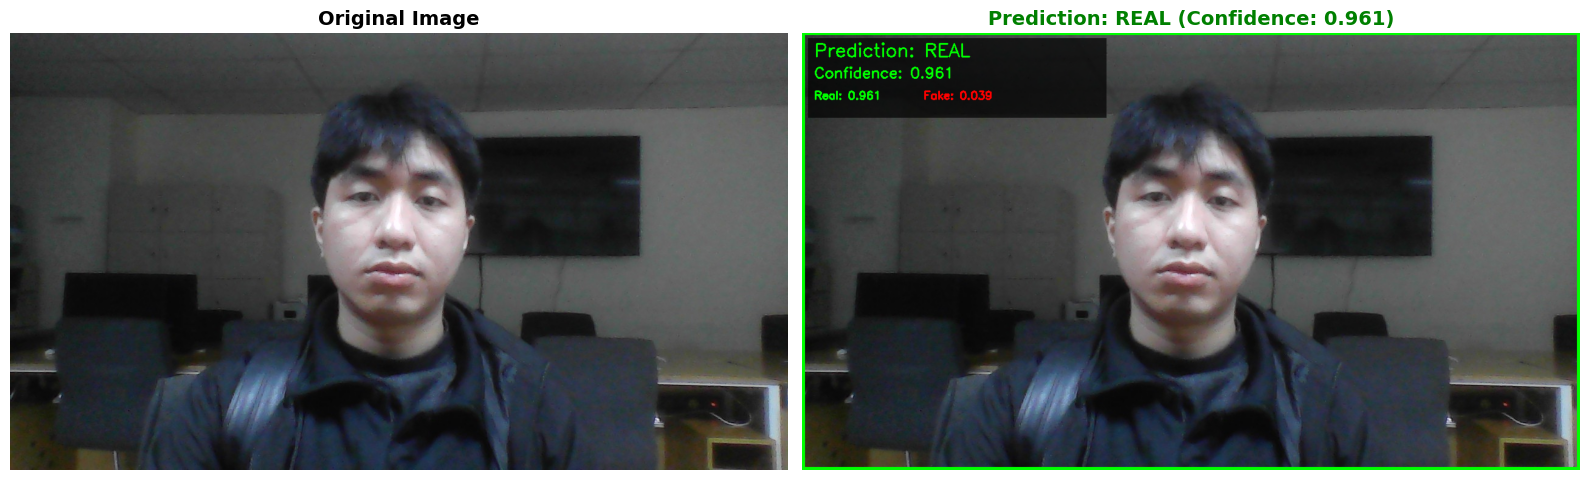

💾 Result saved to: prediction_result.jpg

IMAGE PREDICTION RESULT:
   Class: REAL
   Confidence: 0.9614
   Real probability: 0.9614
   Fake probability: 0.0386
   📈 Confidence level: VERY HIGH

VIDEO INFERENCE
🎥 Processing video: WIN_20251114_18_57_02_Pro.mp4
📊 Video info: 197 frames, sampled 16 frames


Creating result video: 100%|██████████| 197/197 [00:02<00:00, 70.13it/s]


Result video saved to: result_video.mp4

VIDEO PREDICTION RESULT
Final Prediction: REAL
Confidence: 0.9641
Real probability: 0.9641
Fake probability: 0.0359
Total frames: 197
Sampled frames: 16


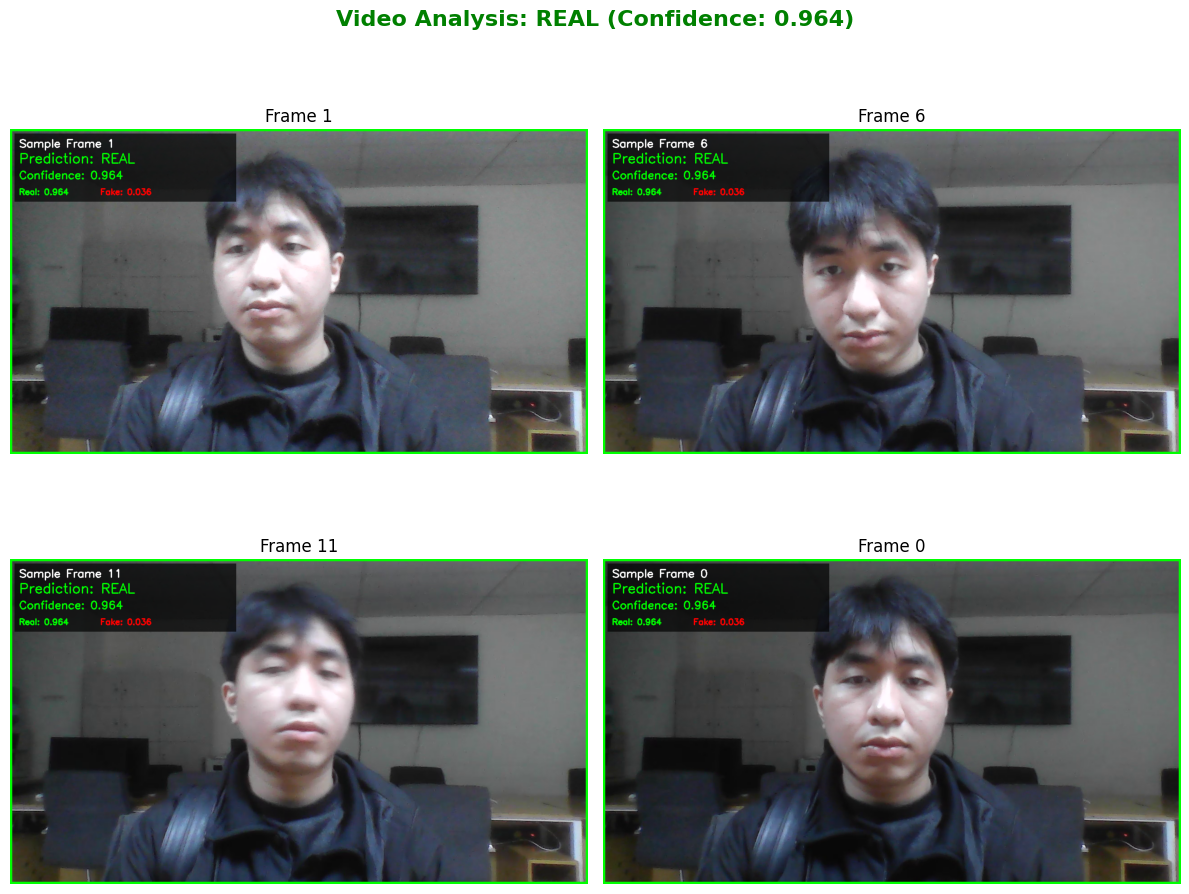


VIDEO PREDICTION RESULT:
   Class: REAL
   Confidence: 0.9641
   Real probability: 0.9641
   Fake probability: 0.0359
   📈 Confidence level: VERY HIGH


In [15]:
#inference
import torch
import torch.nn as nn
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import glob
import os
from pathlib import Path
from decord import VideoReader, cpu
from tqdm import tqdm

class FASInference:
    def __init__(self, model, checkpoint_path, device, frame_size=224, num_frames=16):
        self.model = model
        self.checkpoint_path = checkpoint_path
        self.device = device
        self.frame_size = frame_size
        self.num_frames = num_frames
        
        # Load model weights
        self.load_model()
        
        # Transform cho inference
        self.transform = A.Compose([
            A.Resize(frame_size, frame_size),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2(),
        ])
        
        # Class names
        self.class_names = {0: 'REAL', 1: 'FAKE'}
        self.colors = {0: (0, 255, 0), 1: (255, 0, 0)}  # RGB: Xanh lá: REAL, Đỏ: FAKE
    
    def load_model(self):
        """Load model từ checkpoint"""
        print(f"Loading model from {self.checkpoint_path}...")
        checkpoint = torch.load(self.checkpoint_path, map_location=self.device, weights_only=False)
        
        if 'model_state_dict' in checkpoint:
            self.model.load_state_dict(checkpoint['model_state_dict'])
        else:
            self.model.load_state_dict(checkpoint)
            
        self.model.to(self.device)
        self.model.eval()
        print("✅ Model loaded successfully!")
    
    def preprocess_image(self, image_path):
        """Preprocess image cho inference - trả về RGB"""
        # Đọc ảnh
        image = cv2.imread(image_path)
        if image is None:
            raise ValueError(f"Could not load image from {image_path}")
        
        # Chuyển sang RGB
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        original_size = image_rgb.shape[:2]  # (height, width)
        
        # Tạo multiple frames từ cùng một ảnh
        frames = []
        for _ in range(self.num_frames):
            transformed = self.transform(image=image_rgb)['image']  # (C, H, W)
            frames.append(transformed)
        
        # Stack thành tensor: T x C x H x W
        frames_tensor = torch.stack(frames)
        
        # Tạo mask toàn 1 (tất cả frames đều là thật)
        mask = torch.ones(self.num_frames)
        
        # Thêm batch dimension: 1 x T x C x H x W
        frames_tensor = frames_tensor.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        return frames_tensor, mask, image_rgb, original_size
    
    def preprocess_video(self, video_path):
        """Preprocess video - trả về frames RGB"""
        vr = VideoReader(video_path, ctx=cpu(0))
        total_frames = len(vr)
        
        # Lấy frames đại diện từ toàn bộ video
        if total_frames > self.num_frames:
            # Uniform sampling: lấy đều các frames
            indices = np.linspace(0, total_frames-1, self.num_frames, dtype=int)
            frames = vr.get_batch(indices).asnumpy()  # (T, H, W, C) - RGB
        else:
            # Nếu video ngắn, lấy tất cả frames
            frames = vr.get_batch(list(range(total_frames))).asnumpy()
        
        # Lấy frame đầu tiên để visualization (đã là RGB)
        sample_frame = frames[0] if len(frames) > 0 else None
        
        # Transform frames cho model
        transformed_frames = []
        for frame in frames:
            transformed = self.transform(image=frame)['image']
            transformed_frames.append(transformed)
        
        # Stack thành tensor: T x C x H x W
        frames_tensor = torch.stack(transformed_frames)
        
        # Tạo mask
        mask = torch.ones(self.num_frames)
        if len(frames) < self.num_frames:
            mask[len(frames):] = 0
        
        # Thêm batch dimension
        frames_tensor = frames_tensor.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        return frames_tensor, mask, frames, sample_frame, total_frames
    
    def predict(self, frames_tensor, mask):
        """Dự đoán cho input tensor - trả về prediction cho toàn bộ sequence"""
        with torch.no_grad():
            frames_tensor = frames_tensor.to(self.device)
            mask = mask.to(self.device)
            
            outputs = self.model(frames_tensor)
            probabilities = torch.softmax(outputs, dim=1)
            predicted_class = torch.argmax(outputs, dim=1).item()
            confidence = probabilities[0, predicted_class].item()
            
            return predicted_class, confidence, probabilities.cpu().numpy()[0]
    
    def draw_prediction_on_image(self, image_rgb, prediction, confidence, probabilities, title=None):
        """Vẽ prediction lên ảnh RGB"""
        # Tạo bản copy để vẽ
        result_image = image_rgb.copy()
        h, w = image_rgb.shape[:2]
        
        # Màu dựa trên prediction (RGB format)
        color = self.colors[prediction]
        class_name = self.class_names[prediction]
        
        # Vẽ background cho text (màu đen semi-transparent)
        overlay = result_image.copy()
        text_height = 160 if title else 140
        cv2.rectangle(overlay, (10, 10), (500, text_height), (0, 0, 0), -1)
        result_image = cv2.addWeighted(overlay, 0.7, result_image, 0.3, 0)
        
        # Vẽ text (sử dụng cv2 nhưng với màu RGB)
        font = cv2.FONT_HERSHEY_SIMPLEX
        
        # Thêm title nếu có
        y_offset = 40
        if title:
            cv2.putText(result_image, title, (20, y_offset), font, 0.8, (255, 255, 255), 2)
            y_offset += 35
        
        cv2.putText(result_image, f"Prediction: {class_name}", (20, y_offset), font, 1, color, 2)
        cv2.putText(result_image, f"Confidence: {confidence:.3f}", (20, y_offset + 35), font, 0.8, color, 2)
        cv2.putText(result_image, f"Real: {probabilities[0]:.3f}", (20, y_offset + 70), font, 0.6, (0, 255, 0), 2)
        cv2.putText(result_image, f"Fake: {probabilities[1]:.3f}", (200, y_offset + 70), font, 0.6, (255, 0, 0), 2)
        
        # Vẽ border với màu tương ứng
        cv2.rectangle(result_image, (0, 0), (w-1, h-1), color, 8)
        
        return result_image
    
    def inference_image(self, image_path, save_path=None, display=True):
        """
        Inference cho single image
        Returns: prediction, confidence, probabilities, result_image
        """
        print(f"Processing image: {os.path.basename(image_path)}")
        
        try:
            # Preprocess - trả về ảnh RGB
            frames_tensor, mask, original_image, original_size = self.preprocess_image(image_path)
            
            # Predict
            predicted_class, confidence, probabilities = self.predict(frames_tensor, mask)
            
            # Vẽ kết quả lên ảnh RGB
            result_image = self.draw_prediction_on_image(
                original_image, predicted_class, confidence, probabilities
            )
            
            # Resize về kích thước gốc nếu cần
            if result_image.shape[:2] != original_size:
                result_image = cv2.resize(result_image, (original_size[1], original_size[0]))
            
            # Hiển thị
            if display:
                self._display_image_result(original_image, result_image, predicted_class, confidence)
            
            # Lưu nếu có path
            if save_path:
                # Chuyển sang BGR để lưu với OpenCV
                save_image_bgr = cv2.cvtColor(result_image, cv2.COLOR_RGB2BGR)
                cv2.imwrite(save_path, save_image_bgr)
                print(f"💾 Result saved to: {save_path}")
            
            # Print kết quả
            self._print_prediction_result(predicted_class, confidence, probabilities, "IMAGE")
            
            return predicted_class, confidence, probabilities, result_image
            
        except Exception as e:
            print(f"❌ Error processing image {image_path}: {e}")
            return None, None, None, None
    
    def inference_video(self, video_path, output_path=None, display_samples=True):
        """
        Inference cho toàn bộ video
        Returns: prediction, confidence, probabilities, sample_frames
        """
        print(f"🎥 Processing video: {os.path.basename(video_path)}")
        
        try:
            # Preprocess - trả về frames RGB
            frames_tensor, mask, all_frames, sample_frame, total_frames = self.preprocess_video(video_path)
            
            # Predict TOÀN BỘ VIDEO
            predicted_class, confidence, probabilities = self.predict(frames_tensor, mask)
            
            print(f"📊 Video info: {total_frames} frames, sampled {len(all_frames)} frames")
            
            # Tạo output video với kết quả
            result_frames = []
            if output_path:
                result_frames = self._create_video_with_prediction(
                    video_path, predicted_class, confidence, probabilities, output_path
                )
            
            # Hiển thị kết quả và sample frames
            if display_samples:
                self._display_video_result(all_frames, predicted_class, confidence, probabilities, total_frames)
            
            # Print kết quả
            self._print_prediction_result(predicted_class, confidence, probabilities, "VIDEO")
            
            return predicted_class, confidence, probabilities, result_frames
            
        except Exception as e:
            print(f"❌ Error processing video {video_path}: {e}")
            return None, None, None, None
    
    def _create_video_with_prediction(self, video_path, prediction, confidence, probabilities, output_path):
        """Tạo video kết quả với prediction được vẽ lên mọi frame"""
        try:
            vr = VideoReader(video_path, ctx=cpu(0))
            total_frames = len(vr)
            fps = vr.get_avg_fps()
            
            frame_width = int(vr[0].shape[1])
            frame_height = int(vr[0].shape[0])
            
            fourcc = cv2.VideoWriter_fourcc(*'mp4v')
            out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))
            
            result_frames = []
            
            for i in tqdm(range(total_frames), desc="Creating result video"):
                frame = vr[i].asnumpy()  # RGB từ decord
                
                # Vẽ prediction lên frame
                result_frame = self.draw_prediction_on_image(
                    frame, prediction, confidence, probabilities, 
                    title=f"Frame: {i+1}/{total_frames}"
                )
                
                # Chuyển sang BGR để lưu
                result_frame_bgr = cv2.cvtColor(result_frame, cv2.COLOR_RGB2BGR)
                out.write(result_frame_bgr)
                result_frames.append(result_frame)
            
            out.release()
            print(f"Result video saved to: {output_path}")
            
            return result_frames
            
        except Exception as e:
            print(f"⚠️  Could not create result video: {e}")
            return []
    
    def _display_image_result(self, original_image, result_image, prediction, confidence):
        """Hiển thị kết quả cho ảnh"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
        # Ảnh gốc
        ax1.imshow(original_image)
        ax1.set_title("Original Image", fontsize=14, fontweight='bold')
        ax1.axis('off')
        
        # Ảnh kết quả
        ax2.imshow(result_image)
        ax2.set_title(f"Prediction: {self.class_names[prediction]} (Confidence: {confidence:.3f})", 
                     fontsize=14, fontweight='bold',
                     color='green' if prediction == 0 else 'red')
        ax2.axis('off')
        
        plt.tight_layout()
        plt.show()
    
    def _display_video_result(self, frames, prediction, confidence, probabilities, total_frames):
        """Hiển thị kết quả và sample frames từ video"""
        print(f"\n{'='*60}")
        print(f"VIDEO PREDICTION RESULT")
        print(f"{'='*60}")
        print(f"Final Prediction: {self.class_names[prediction]}")
        print(f"Confidence: {confidence:.4f}")
        print(f"Real probability: {probabilities[0]:.4f}")
        print(f"Fake probability: {probabilities[1]:.4f}")
        print(f"Total frames: {total_frames}")
        print(f"Sampled frames: {len(frames)}")
        print(f"{'='*60}")
        
        # Hiển thị sample frames
        if len(frames) >= 4:
            fig, axes = plt.subplots(2, 2, figsize=(12, 10))
            axes = axes.flatten()
            
            sample_indices = [0, len(frames)//3, 2*len(frames)//3, -1]
            
            for i, idx in enumerate(sample_indices):
                if idx < len(frames):
                    # Vẽ prediction lên sample frames
                    sample_with_pred = self.draw_prediction_on_image(
                        frames[idx], prediction, confidence, probabilities,
                        title=f"Sample Frame {idx+1}"
                    )
                    axes[i].imshow(sample_with_pred)
                    axes[i].set_title(f"Frame {idx+1}")
                    axes[i].axis('off')
            
            plt.suptitle(f"Video Analysis: {self.class_names[prediction]} (Confidence: {confidence:.3f})", 
                        fontsize=16, fontweight='bold',
                        color='green' if prediction == 0 else 'red')
            plt.tight_layout()
            plt.show()
    
    def _print_prediction_result(self, prediction, confidence, probabilities, input_type):
        """In kết quả prediction"""
        print(f"\n{input_type} PREDICTION RESULT:")
        print(f"   Class: {self.class_names[prediction]}")
        print(f"   Confidence: {confidence:.4f}")
        print(f"   Real probability: {probabilities[0]:.4f}")
        print(f"   Fake probability: {probabilities[1]:.4f}")
        
        # Phân tích confidence level
        if confidence > 0.9:
            confidence_level = "VERY HIGH"
        elif confidence > 0.7:
            confidence_level = "HIGH"
        elif confidence > 0.5:
            confidence_level = "MEDIUM"
        else:
            confidence_level = "LOW"
        
        print(f"   📈 Confidence level: {confidence_level}")

    def inference_batch(self, input_folder, output_folder=None, file_types=['jpg', 'jpeg', 'png', 'mp4', 'avi']):
        """Inference cho batch files (cả ảnh và video)"""
        print(f"📦 Processing batch from: {input_folder}")
        
        if output_folder:
            os.makedirs(output_folder, exist_ok=True)
        
        results = []
        
        # Tìm tất cả files
        for file_type in file_types:
            pattern = os.path.join(input_folder, f"*.{file_type}")
            files = glob.glob(pattern) + glob.glob(pattern.upper())
            
            for file_path in files:
                print(f"\n{'='*50}")
                
                try:
                    if file_type.lower() in ['jpg', 'jpeg', 'png']:
                        # Inference ảnh
                        if output_folder:
                            save_path = os.path.join(output_folder, f"pred_{os.path.basename(file_path)}")
                        else:
                            save_path = None
                        
                        pred_class, confidence, probs, result_img = self.inference_image(
                            file_path, save_path, display=False
                        )
                        
                        result_type = "IMAGE"
                        
                    else:
                        # Inference video
                        if output_folder:
                            save_path = os.path.join(output_folder, f"pred_{os.path.basename(file_path)}")
                        else:
                            save_path = None
                        
                        pred_class, confidence, probs, result_frames = self.inference_video(
                            file_path, save_path, display_samples=False
                        )
                        
                        result_type = "VIDEO"
                    
                    if pred_class is not None:
                        results.append({
                            'file_path': file_path,
                            'type': result_type,
                            'predicted_class': pred_class,
                            'class_name': self.class_names[pred_class],
                            'confidence': confidence,
                            'probabilities': probs
                        })
                        
                        print(f"✅ {result_type}: {self.class_names[pred_class]} ({confidence:.3f})")
                    
                except Exception as e:
                    print(f"❌ Error processing {file_path}: {e}")
                    continue
        
        # Print batch summary
        if results:
            self._print_batch_summary(results)
        
        return results
    
    def _print_batch_summary(self, results):
        """In summary cho batch inference"""
        real_count = sum(1 for r in results if r['predicted_class'] == 0)
        fake_count = sum(1 for r in results if r['predicted_class'] == 1)
        images_count = sum(1 for r in results if r['type'] == 'IMAGE')
        videos_count = sum(1 for r in results if r['type'] == 'VIDEO')
        
        print(f"\n{'='*60}")
        print(f"📊 BATCH INFERENCE SUMMARY")
        print(f"{'='*60}")
        print(f"Total files processed: {len(results)}")
        print(f"Images: {images_count}")
        print(f"Videos: {videos_count}")
        print(f"REAL predictions: {real_count} ({real_count/len(results)*100:.1f}%)")
        print(f"FAKE predictions: {fake_count} ({fake_count/len(results)*100:.1f}%)")
        print(f"Average confidence: {np.mean([r['confidence'] for r in results]):.3f}")

# Example usage
def main():
    # Device
    # device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Khởi tạo inference engine
    inference_engine = FASInference(
        model=model,
        checkpoint_path="/kaggle/input/stdl-facepad/pytorch/default/1/checkpoint_epoch_11.pth",
        device=device,
        frame_size=config["frame_size"],
        num_frames=config["num_frames"]
    )
    
    # 🔹 INFERENCE CHO ẢNH
    print("\n" + "="*60)
    print("IMAGE INFERENCE")
    print("="*60)
    inference_engine.inference_image(
        image_path="/kaggle/input/inference/WIN_20251114_18_56_01_Pro.jpg",
        save_path="prediction_result.jpg"
    )
    
    # 🔹 INFERENCE CHO VIDEO
    print("\n" + "="*60)
    print("VIDEO INFERENCE")
    print("="*60)
    inference_engine.inference_video(
        video_path="/kaggle/input/inference/WIN_20251114_18_57_02_Pro.mp4",
        output_path="result_video.mp4"
    )
    
    # # 🔹 INFERENCE BATCH
    # print("\n" + "="*60)
    # print("📦 BATCH INFERENCE")
    # print("="*60)
    # results = inference_engine.inference_batch(
    #     input_folder="./test_data",
    #     output_folder="./prediction_results"
    # )

if __name__ == "__main__":
    main()

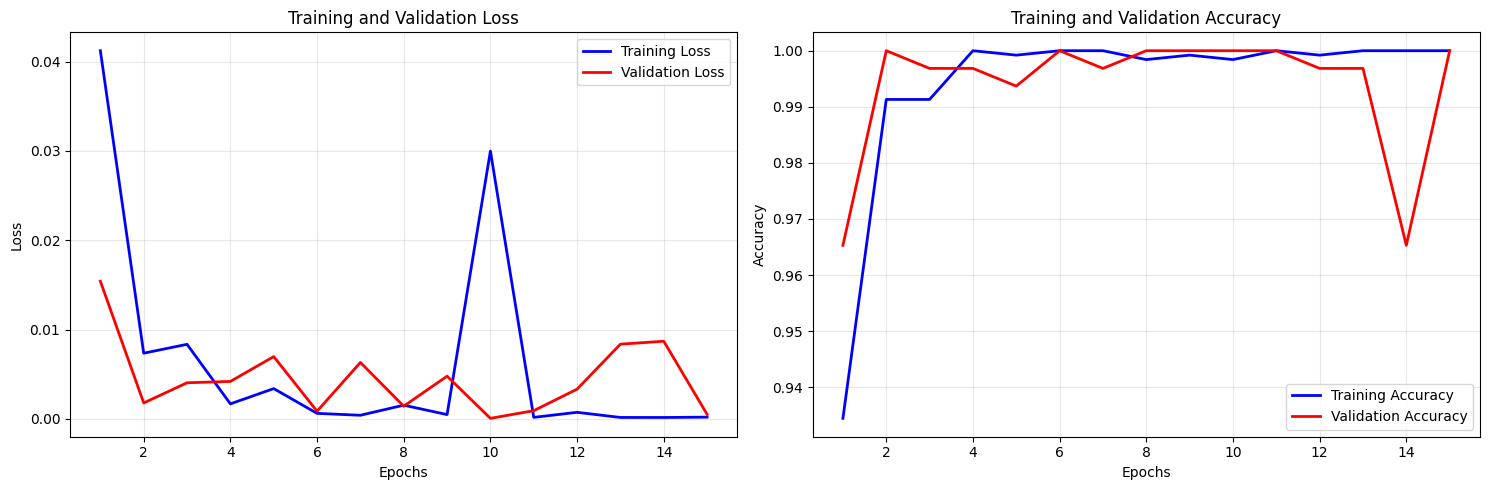

In [63]:
#Plot
plot_training_history(history)